In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import glob, pylab, pandas as pd
import pydicom, numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt
import os
import seaborn as sns
import warnings
warnings.filterwarnings(action='once')
import pickle
from tqdm import tqdm, tqdm_notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
from helper import *
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from defenitions import *

/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
data_dir = '/media/nvme/data/RSNA/'
train_images_dir=data_dir+'stage_1_train_images/'
test_images_dir=data_dir+'stage_1_test_images/'

In [3]:
train_base_df = pd.read_csv(data_dir+'stage_1_train.csv')

In [67]:
train_base_df.shape[0]

4045572

In [68]:
train_base_df.ID.unique().shape[0]

4045548

In [71]:
train_base_df[train_base_df.duplicated()]
train_base_df[train_base_df.duplicated()].shape[0]

,ID,Label
312474,ID_a64d5deed_epidural,0
312475,ID_a64d5deed_intraparenchymal,0
312476,ID_a64d5deed_intraventricular,0
312477,ID_a64d5deed_subarachnoid,0
312478,ID_a64d5deed_subdural,0
312479,ID_a64d5deed_any,0
1598544,ID_921490062_epidural,0
1598545,ID_921490062_intraparenchymal,0
1598546,ID_921490062_intraventricular,0
1598547,ID_921490062_subarachnoid,0


24

63.0

In [3]:
sample_submission=pd.read_csv(data_dir+'stage_1_sample_submission.csv')
sample_submission.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5


In [4]:
test_base_df=sample_submission.copy()
test_base_df['Sub_type'] = test_base_df['ID'].str.split("_", n = 3, expand = True)[2]
test_base_df['PatientID'] = test_base_df['ID'].str.split("_", n = 3, expand = True)[1]
test_base_df.head()

,ID,Label,Sub_type,PatientID
0,ID_28fbab7eb_epidural,0.5,epidural,28fbab7eb
1,ID_28fbab7eb_intraparenchymal,0.5,intraparenchymal,28fbab7eb
2,ID_28fbab7eb_intraventricular,0.5,intraventricular,28fbab7eb
3,ID_28fbab7eb_subarachnoid,0.5,subarachnoid,28fbab7eb
4,ID_28fbab7eb_subdural,0.5,subdural,28fbab7eb


In [234]:
test_ids=test_df.PatientID.unique()

In [23]:
train_base_df['Sub_type'] = train_base_df['ID'].str.split("_", n = 3, expand = True)[2]
train_base_df['PatientID'] = train_base_df['ID'].str.split("_", n = 3, expand = True)[1]

In [24]:
train_base_df.head(10)

,ID,Label,Sub_type,PatientID
0,ID_63eb1e259_epidural,0,epidural,63eb1e259
1,ID_63eb1e259_intraparenchymal,0,intraparenchymal,63eb1e259
2,ID_63eb1e259_intraventricular,0,intraventricular,63eb1e259
3,ID_63eb1e259_subarachnoid,0,subarachnoid,63eb1e259
4,ID_63eb1e259_subdural,0,subdural,63eb1e259
5,ID_63eb1e259_any,0,any,63eb1e259
6,ID_2669954a7_epidural,0,epidural,2669954a7
7,ID_2669954a7_intraparenchymal,0,intraparenchymal,2669954a7
8,ID_2669954a7_intraventricular,0,intraventricular,2669954a7
9,ID_2669954a7_subarachnoid,0,subarachnoid,2669954a7


In [26]:
sub_types=train_base_df.Sub_type.unique()
sub_types

array(['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid',
       'subdural', 'any'], dtype=object)

In [27]:
dfs =[]
for sub_type in tqdm_notebook(sub_types):
    df = train_base_df[train_base_df.Sub_type==sub_type][['PatientID','Label']].copy()
    df=df.rename(columns={"Label": sub_type}).reset_index(drop=True)
    dfs.append(df)

In [85]:
train_meta_df=pd.read_csv(data_dir+'train_metadata.csv')
train_meta_df.head()
train_meta_df.info()

train_meta_df['magic']=((train_meta_df.pxl_min<-3000) & (train_meta_df.pxl_min>-3100))

magic_df=train_meta_df[['series_instance_uid','magic']].groupby('series_instance_uid').magic.mean().reset_index()

magic_df['series_instance_uid'] = magic_df['series_instance_uid'].str.split("_", n = 3, expand = True)[1]
magic_df.head()

magic_df.magic=magic_df.magic>0.5

magic_df.head()

,sop_instance_uid,modality,patient_id,study_instance_uid,series_instance_uid,study_id,image_position_patient,image_orientation_patient,samples_per_pixel,photometric_interpretation,...,high_bit,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope,pxl_min,pxl_max,pxl_std,pxl_mean
0,ID_231d901c1,CT,ID_b81a287f,ID_dd37ba3adb,ID_15dcd6057a,NaN,"['-125.000', '-123.101', '104.307']","['1.000000', '0.000000', '0.000000', '0.000000...",1,MONOCHROME2,...,15,1,40,100,-1024.0,1.0,-2048,2239,828.102464,-852.537510
1,ID_994bc0470,CT,ID_400facde,ID_c5277f0c63,ID_4ba12c2161,NaN,"['-125', '53.6282216', '223.572015']","['1', '0', '0', '0', '0.933580426', '-0.358367...",1,MONOCHROME2,...,11,0,"['00047', '00047']","['00080', '00080']",-1024.0,1.0,-1024,1483,599.742963,-593.581909
2,ID_127689cce,CT,ID_42910d3d,ID_db93ade25b,ID_c4b4931314,NaN,"['-125.000000', '-123.646240', '124.321068']","['1.000000', '0.000000', '0.000000', '0.000000...",1,MONOCHROME2,...,15,1,30,80,-1024.0,1.0,-3024,1786,1209.046168,-1011.198624
3,ID_25457734a,CT,ID_329aafa7,ID_8dd6d32f3b,ID_116558f409,NaN,"['-114', '-6', '171.999939']","['1', '0', '0', '0', '1', '0']",1,MONOCHROME2,...,11,0,"['00036', '00036']","['00080', '00080']",-1024.0,1.0,-1024,1623,610.152845,-457.442989
4,ID_81c9aa125,CT,ID_6b544c3c,ID_2685c5d5c0,ID_f56d7bd0f9,NaN,"['-115', '-1', '230.5']","['1', '0', '0', '0', '1', '0']",1,MONOCHROME2,...,11,0,"['00036', '00036']","['00080', '00080']",-1024.0,1.0,-1020,546,358.235071,-845.487705


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674257 entries, 0 to 674256
Data columns (total 25 columns):
sop_instance_uid              674257 non-null object
modality                      674257 non-null object
patient_id                    674257 non-null object
study_instance_uid            674257 non-null object
series_instance_uid           674257 non-null object
study_id                      0 non-null float64
image_position_patient        674257 non-null object
image_orientation_patient     674257 non-null object
samples_per_pixel             674257 non-null int64
photometric_interpretation    674257 non-null object
rows                          674257 non-null int64
columns                       674257 non-null int64
pixel_spacing                 674257 non-null object
bits_allocated                674257 non-null int64
bits_stored                   674257 non-null int64
high_bit                      674257 non-null int64
pixel_representation          674257 non-null int64

,series_instance_uid,magic
0,0000298a7d,1.0
1,0004c4e54c,1.0
2,000a935543,1.0
3,000f6fd7db,0.0
4,001231935f,0.0


,series_instance_uid,magic
0,0000298a7d,True
1,0004c4e54c,True
2,000a935543,True
3,000f6fd7db,False
4,001231935f,False


In [89]:
magic_df.magic.mean()

0.32677931387608805

In [91]:
muid=set(magic_df[magic_df.magic].series_instance_uid.values)

In [94]:
train_df[train_df.SeriesI.isin(muid)]['any'].mean()

0.06497603992026509

In [95]:
train_df[~train_df.SeriesI.isin(muid)]['any'].mean()

0.18409326181591346

In [79]:
test_meta_df=pd.read_csv(data_dir+'test_metadata.csv')
test_meta_df.head()
test_meta_df.info()

test_meta_df['magic']=((test_meta_df.pxl_min<-3000) & (test_meta_df.pxl_min>-3100))

test_magic_df=test_meta_df[['series_instance_uid','magic']].groupby('series_instance_uid').magic.mean().reset_index()

test_magic_df['series_instance_uid'] = test_magic_df['series_instance_uid'].str.split("_", n = 3, expand = True)[1]
test_magic_df.head()

test_magic_df.magic=test_magic_df.magic>0.5

test_magic_df.head()

,sop_instance_uid,modality,patient_id,study_instance_uid,series_instance_uid,study_id,image_position_patient,image_orientation_patient,samples_per_pixel,photometric_interpretation,...,high_bit,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope,pxl_min,pxl_max,pxl_std,pxl_mean
0,ID_cec48be98,CT,ID_02159492,ID_6d53e6b7a1,ID_8a81168925,NaN,"['-125.000', '-141.990', '132.483']","['1.000000', '0.000000', '0.000000', '0.000000...",1,MONOCHROME2,...,15,1,30,80,-1024.0,1.0,-3024,1757,1226.462247,-934.577675
1,ID_24499006f,CT,ID_d11a0081,ID_816f37dbe8,ID_d06566b389,NaN,"['-125.000000', '-132.714630', '168.437393']","['1.000000', '0.000000', '0.000000', '0.000000...",1,MONOCHROME2,...,15,1,30,80,-1024.0,1.0,-3024,378,918.661831,-1333.280270
2,ID_398dc0001,CT,ID_c4cc9737,ID_5f64ee7147,ID_ffa52dd6f4,NaN,"['-125.000', '-143.133', '210.935']","['1.000000', '0.000000', '0.000000', '0.000000...",1,MONOCHROME2,...,15,1,30,80,-1024.0,1.0,-3024,319,868.844182,-1385.514153
3,ID_b6b34b14f,CT,ID_70762000,ID_79ee2c9970,ID_ace884ca18,NaN,"['-125.000000', '-115.897980', '153.461166']","['1.000000', '0.000000', '0.000000', '0.000000...",1,MONOCHROME2,...,15,1,30,80,-1024.0,1.0,-3024,1655,1172.545380,-1041.369213
4,ID_6cab4d011,CT,ID_651ef9ca,ID_6b8d99fa5a,ID_bc28f24d1d,NaN,"['-125.000000', '-109.697983', '113.566208']","['1.000000', '0.000000', '0.000000', '0.000000...",1,MONOCHROME2,...,15,1,30,80,-1024.0,1.0,-3024,1789,1248.369159,-919.330597


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78545 entries, 0 to 78544
Data columns (total 25 columns):
sop_instance_uid              78545 non-null object
modality                      78545 non-null object
patient_id                    78545 non-null object
study_instance_uid            78545 non-null object
series_instance_uid           78545 non-null object
study_id                      0 non-null float64
image_position_patient        78545 non-null object
image_orientation_patient     78545 non-null object
samples_per_pixel             78545 non-null int64
photometric_interpretation    78545 non-null object
rows                          78545 non-null int64
columns                       78545 non-null int64
pixel_spacing                 78545 non-null object
bits_allocated                78545 non-null int64
bits_stored                   78545 non-null int64
high_bit                      78545 non-null int64
pixel_representation          78545 non-null int64
window_center    

,series_instance_uid,magic
0,0010b2528e,1.0
1,005038b82e,1.0
2,0051caea1e,1.0
3,00625d88e3,1.0
4,007f08f952,1.0


,series_instance_uid,magic
0,0010b2528e,True
1,005038b82e,True
2,0051caea1e,True
3,00625d88e3,True
4,007f08f952,True


In [80]:
full_magic_df=pd.concat([magic_df,test_magic_df])

In [81]:
full_magic_df.head(10)
full_magic_df.shape
magic_df.shape
test_magic_df.shape

,series_instance_uid,magic
0,0000298a7d,True
1,0004c4e54c,True
2,000a935543,True
3,000f6fd7db,False
4,001231935f,False
5,00175b0c48,False
6,0018a8a4a8,True
7,001a368147,True
8,002bc432f1,True
9,002c873783,False


(21744, 2)

(19530, 2)

(2214, 2)

In [82]:
full_magic_df.to_csv(data_dir+'magic_df.csv',index=False)

In [84]:
dict(full_magic_df.values)

{'0000298a7d': True,
 '0004c4e54c': True,
 '000a935543': True,
 '000f6fd7db': False,
 '001231935f': False,
 '00175b0c48': False,
 '0018a8a4a8': True,
 '001a368147': True,
 '002bc432f1': True,
 '002c873783': False,
 '002c9733b7': False,
 '002ee68337': True,
 '003007d953': False,
 '00344d72f8': True,
 '0035e7ea58': True,
 '0037be4db7': True,
 '003df1f5a6': True,
 '0040e8628b': False,
 '00422c592a': False,
 '004a886d8d': False,
 '004d738431': True,
 '004ff2a4c8': False,
 '0058c5dc88': True,
 '00593403fc': True,
 '00593e5f5c': False,
 '005a1a9ae9': False,
 '005b0941fa': False,
 '005e302f81': False,
 '0060822d07': False,
 '0065ec9acc': False,
 '0068ebfbfb': True,
 '006d2bfda3': False,
 '006fb4afb7': True,
 '00749ea2e0': False,
 '0076c128f2': False,
 '0079297d94': True,
 '007c9a69fc': True,
 '008545910b': True,
 '0088753bd2': False,
 '0088f6bdf7': False,
 '008d06cb2d': False,
 '008d5bbf7b': False,
 '0092870e51': False,
 '0092fae4c8': False,
 '00930c5e4d': True,
 '0098e41687': False,
 '009a66

In [97]:
train_min=train_df[['SeriesI','ImagePositionZ','ImagePositionX','ImagePositionY']].groupby('SeriesI').min()
train_min.head()
train_max=train_df[['SeriesI','ImagePositionZ','ImagePositionX','ImagePositionY']].groupby('SeriesI').max()
train_max.head()

,ImagePositionZ,ImagePositionX,ImagePositionY
SeriesI,,,
0000298a7d,46.633000,-125.0,-147.231000
0004c4e54c,10.730179,-125.0,-101.589821
000a935543,49.170990,-125.0,-122.490585
000f6fd7db,65.000000,-121.0,0.000000
001231935f,102.699951,-125.0,-31.000000


,ImagePositionZ,ImagePositionX,ImagePositionY
SeriesI,,,
0000298a7d,202.877000,-125.0,-147.231000
0004c4e54c,153.494492,-125.0,-101.589821
000a935543,207.348297,-125.0,-122.490585
000f6fd7db,220.000000,-121.0,0.000000
001231935f,242.699951,-125.0,-31.000000


In [121]:
train_df[train_df.PID=='018b83e7'].sample(10)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
230798,d069d36f7,0,0,0,0,0,0,018b83e7,3adb11db7b,8b19ce5b7e,"['00036', '00036']","['00080', '00080']",422.000000,-105.50000,33.50000
380055,fe5014ae3,0,0,0,0,0,0,018b83e7,3b7e6f08b5,0a633b6bcc,"['00036', '00036']","['00080', '00080']",78.500000,-112.50000,74.50000
360875,d6bc60397,0,0,0,0,0,0,018b83e7,3331f55013,8f1d6547bb,"['00036', '00036']","['00080', '00080']",113.000000,-110.50000,9.50000
116861,be8b3fa69,0,0,0,0,0,0,018b83e7,6cf6584912,fd2f967a00,"['00036', '00036']","['00080', '00080']",251.500000,-111.50000,11.50000
633280,db8fc6d9e,0,0,0,1,0,1,018b83e7,32a982dd62,5eb6c0e3fc,"['00036', '00036']","['00080', '00080']",316.000000,-110.50000,8.50000
128291,4c928e327,0,0,0,0,0,0,018b83e7,3331f55013,8f1d6547bb,"['00036', '00036']","['00080', '00080']",128.000000,-110.50000,9.50000
509040,d7a0fd133,0,1,0,1,0,1,018b83e7,3adb11db7b,8b19ce5b7e,"['00036', '00036']","['00080', '00080']",517.000061,-105.50000,33.50000
656510,9271de637,0,1,0,1,0,1,018b83e7,32a982dd62,5eb6c0e3fc,"['00036', '00036']","['00080', '00080']",361.000000,-110.50000,8.50000
208465,36108c996,0,0,0,0,0,0,018b83e7,ba1c7199ef,91616854b0,"['00036', '00036']","['00080', '00080']",218.899963,-122.73329,45.99968
343367,21af9ff69,0,0,0,0,0,0,018b83e7,3331f55013,8f1d6547bb,"['00036', '00036']","['00080', '00080']",108.000000,-110.50000,9.50000


In [120]:
train_u=train_df[['PID','SeriesI']].groupby('PID').count().reset_index()
train_u[train_u.SeriesI>60].head(30)

,PID,SeriesI
4,000e5623,67
9,00257f20,64
17,00526c11,84
39,00a3b735,144
54,00d96858,96
58,00e09272,64
75,011e2d12,82
83,01484d74,62
93,016cf509,70
101,018b7c8c,62


In [128]:
a=np.arange(10)*10
b=np.arange(10)
c=np.zeros((2,10))
c[0]=b
c[1]=a
d=np.arange(10)

np.random.shuffle(d)
c=c[...,d]
c
np.random.shuffle(d)
e=c[...,d]
e

array([[ 5.,  3.,  2.,  8.,  9.,  7.,  4.,  6.,  0.,  1.],
       [50., 30., 20., 80., 90., 70., 40., 60.,  0., 10.]])

array([[ 1.,  3.,  2.,  0.,  7.,  6.,  8.,  4.,  5.,  9.],
       [10., 30., 20.,  0., 70., 60., 80., 40., 50., 90.]])

In [157]:
c
e
x = np.argsort(c[0])
y = np.argsort(e[0])
z=np.arange(10)
x
y
z=np.argsort(np.argsort(c[0]))
e[...,np.argsort(e[0])[np.argsort(np.argsort(c[0]))]]

array([[ 5.,  3.,  2.,  8.,  9.,  7.,  4.,  6.,  0.,  1.],
       [50., 30., 20., 80., 90., 70., 40., 60.,  0., 10.]])

array([[ 1.,  3.,  2.,  0.,  7.,  6.,  8.,  4.,  5.,  9.],
       [10., 30., 20.,  0., 70., 60., 80., 40., 50., 90.]])

array([8, 9, 2, 1, 6, 0, 7, 5, 3, 4])

array([3, 0, 2, 1, 7, 8, 5, 4, 6, 9])

array([[ 5.,  3.,  2.,  8.,  9.,  7.,  4.,  6.,  0.,  1.],
       [50., 30., 20., 80., 90., 70., 40., 60.,  0., 10.]])

In [106]:
(train_max.values-train_min.values).max(0)
np.argmax(train_max.values-train_min.values,0)

array([284.99999957,  43.        ,  56.7854362 ])

array([10594, 10710, 17420])

In [107]:
train_max.index[17420]

'e4909e7c46'

In [110]:
train_df[train_df.SeriesI=='e4909e7c46'].sort_values('ImagePositionZ').head(60)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
276962,bd953a7b3,0,0,0,0,0,0,b91458d9,e78a2774ef,e4909e7c46,"['40', '40']","['80', '80']",145.416091,-130.274258,-15.011064
51610,8ad1fe6cb,0,0,0,0,0,0,b91458d9,e78a2774ef,e4909e7c46,"['40', '40']","['80', '80']",149.777453,-130.009160,-12.907899
380698,266579eb2,0,0,0,0,0,0,b91458d9,e78a2774ef,e4909e7c46,"['40', '40']","['80', '80']",154.138815,-129.744063,-10.804735
617628,44486b5cb,0,0,0,0,0,0,b91458d9,e78a2774ef,e4909e7c46,"['40', '40']","['80', '80']",158.500178,-129.478965,-8.701571
368996,f69460f66,0,0,0,0,0,0,b91458d9,e78a2774ef,e4909e7c46,"['40', '40']","['80', '80']",162.861540,-129.213867,-6.598406
152889,7d38f0a81,0,0,0,0,0,0,b91458d9,e78a2774ef,e4909e7c46,"['40', '40']","['80', '80']",167.222902,-128.948769,-4.495242
45710,c125faf12,0,0,0,0,0,0,b91458d9,e78a2774ef,e4909e7c46,"['40', '40']","['80', '80']",171.584265,-128.683671,-2.392078
614846,af4ac878a,0,0,0,0,0,0,b91458d9,e78a2774ef,e4909e7c46,"['40', '40']","['80', '80']",175.945627,-128.418573,-0.288913
511238,8d227383c,0,0,0,0,0,0,b91458d9,e78a2774ef,e4909e7c46,"['40', '40']","['80', '80']",180.306989,-128.153475,1.814251
389262,f1e50be6f,0,0,0,0,0,0,b91458d9,e78a2774ef,e4909e7c46,"['40', '40']","['80', '80']",184.668352,-127.888377,3.917415


In [112]:
test_df.PID.unique().shape
test_df.SeriesI.unique().shape

(2144,)

(2214,)

In [113]:
train_df.PID.unique().shape
train_df.SeriesI.unique().shape

(17079,)

(19530,)

In [64]:
train_base_df.shape[0]/6
train_base_df.ID.unique().shape[0]/6

674262.0

674258.0

In [62]:

train_base_df[train_base_df.PatientID=='a64d5deed']

,ID,Label,Sub_type,PatientID
312468,ID_a64d5deed_epidural,0,epidural,a64d5deed
312469,ID_a64d5deed_intraparenchymal,0,intraparenchymal,a64d5deed
312470,ID_a64d5deed_intraventricular,0,intraventricular,a64d5deed
312471,ID_a64d5deed_subarachnoid,0,subarachnoid,a64d5deed
312472,ID_a64d5deed_subdural,0,subdural,a64d5deed
312473,ID_a64d5deed_any,0,any,a64d5deed
312474,ID_a64d5deed_epidural,0,epidural,a64d5deed
312475,ID_a64d5deed_intraparenchymal,0,intraparenchymal,a64d5deed
312476,ID_a64d5deed_intraventricular,0,intraventricular,a64d5deed
312477,ID_a64d5deed_subarachnoid,0,subarachnoid,a64d5deed


In [7]:
dfs =[]
for sub_type in tqdm_notebook(sub_types):
    df = test_base_df[test_base_df.Sub_type==sub_type][['PatientID','Label']].copy()
    df=df.rename(columns={"Label": sub_type}).reset_index(drop=True)
    dfs.append(df)
test_df=dfs[0]
for df in tqdm_notebook(dfs[1:]):
    test_df=test_df.merge(df,on='PatientID')

In [8]:
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5


In [11]:
PID = np.zeros(test_df.shape[0],dtype=object)
StudyI = np.zeros(test_df.shape[0],dtype=object)
SeriesI = np.zeros(test_df.shape[0],dtype=object)
WindowCenter = np.zeros(test_df.shape[0],dtype=object)
WindowWidth = np.zeros(test_df.shape[0],dtype=object)
ImagePositionX = np.zeros(test_df.shape[0],dtype=np.float)
ImagePositionY = np.zeros(test_df.shape[0],dtype=np.float)
ImagePositionZ = np.zeros(test_df.shape[0],dtype=np.float)

for i,row in tqdm_notebook(test_df.iterrows(),total=test_df.shape[0]):
    ds = pydicom.dcmread(test_images_dir + 'ID_{}.dcm'.format(row['PatientID']))
    SeriesI[i]=ds.SeriesInstanceUID
    PID[i]=ds.PatientID
    StudyI[i]=ds.StudyInstanceUID 
    WindowCenter[i]=ds.WindowCenter
    WindowWidth[i]=ds.WindowWidth
    ImagePositionX[i]=float(ds.ImagePositionPatient[0])
    ImagePositionY[i]=float(ds.ImagePositionPatient[1])
    ImagePositionZ[i]=float(ds.ImagePositionPatient[2])
test_df['SeriesI']=SeriesI
test_df['PID']=PID
test_df['StudyI']=StudyI
test_df['WindowCenter']=WindowCenter
test_df['WindowWidth']=WindowWidth
test_df['ImagePositionZ']=ImagePositionZ
test_df['ImagePositionX']=ImagePositionX
test_df['ImagePositionY']=ImagePositionY


In [22]:
test_df['SeriesI'] = test_df['SeriesI'].str.split("_", n = 3, expand = True)[1]
test_df['PID'] = test_df['PID'].str.split("_", n = 3, expand = True)[1]
test_df['StudyI'] = test_df['StudyI'].str.split("_", n = 3, expand = True)[1]
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819


In [23]:

test_df.to_csv(data_dir+'test.csv',index=False)

In [28]:
train_df0=dfs[0]
for df in tqdm_notebook(dfs[1:]):
    train_df0=train_df0.merge(df,on='PatientID')

In [58]:
a=np.where(dfs[0].merge(dfs[1],on='PatientID').duplicated())
dfs[0].merge(dfs[1],on='PatientID').iloc()[a]

,PatientID,epidural,intraparenchymal
52079,a64d5deed,0,0
52080,a64d5deed,0,0
52081,a64d5deed,0,0
266426,921490062,0,0
266427,921490062,0,0
266428,921490062,0,0
451455,489ae4179,0,0
451456,489ae4179,0,0
451457,489ae4179,0,0
505506,854fba667,0,0


In [59]:
dfs[0][dfs[0].PatientID=='a64d5deed'].head()

,PatientID,epidural
52078,a64d5deed,0
52079,a64d5deed,0


In [60]:
dfs[1][dfs[1].PatientID=='a64d5deed'].head()

,PatientID,intraparenchymal
52078,a64d5deed,0
52079,a64d5deed,0


In [ ]:
pd.merge()

In [29]:
train_df.head()
train_df.shape

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


(674510, 15)

In [30]:
train_df.PatientID.unique().shape

(674258,)

In [51]:
(674510-674258)/6

42.0

In [18]:
train_df.to_csv(data_dir+'train.csv',index=False)

In [3]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [62]:
dcm_data = pydicom.dcmread(train_images_dir+'ID_{}.dcm'.format('f35239b62'))

In [64]:
pydicom.dcmread(train_images_dir+'ID_{}.dcm'.format('f93e911c4'))

(0008, 0018) SOP Instance UID                    UI: ID_f93e911c4
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_16205502'
(0020, 000d) Study Instance UID                  UI: ID_8d29717448
(0020, 000e) Series Instance UID                 UI: ID_85025568b1
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '-12.7894726', '173.099976']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '1', '0']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 12
(0028, 0102) H

In [65]:
pydicom.dcmread(train_images_dir+'ID_{}.dcm'.format('766f5ce99'))

(0008, 0018) SOP Instance UID                    UI: ID_766f5ce99
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_dfd11f1c'
(0020, 000d) Study Instance UID                  UI: ID_bb068ecae8
(0020, 000e) Series Instance UID                 UI: ID_2ee5298f4f
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-122.496143', '-35.236501', '202']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '1', '0']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 12
(0028, 0102) Hi

In [63]:
dcm_data

(0008, 0018) SOP Instance UID                    UI: ID_f35239b62
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_ef846fd7'
(0020, 000d) Study Instance UID                  UI: ID_03bebb580f
(0020, 000e) Series Instance UID                 UI: ID_b268bd9c68
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '56.3448799', '197.367211']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '0.913545458', '-0.406736643']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         U

In [9]:
int(dcm_data['RescaleIntercept'].value)

-1024

In [12]:
ar=np.zeros((train_df.shape[0],4),dtype=np.int)
fields=['BitsStored','PixelRepresentation','RescaleIntercept','RescaleSlope']
for i,pid in enumerate(tqdm_notebook(train_df.PatientID.values)):
    dcm_data = pydicom.dcmread(train_images_dir+'ID_{}.dcm'.format(pid))
    for j,field in enumerate(fields):
        ar[i,j]=int(dcm_data[field].value)
    

In [21]:
bits_df=pd.DataFrame(index=np.arange(train_df.shape[0]),columns=['PatientID','BitsStored','PixelRepresentation','RescaleIntercept','RescaleSlope'])

In [23]:
bits_df.PatientID=train_df.PatientID
bits_df[fields]=ar

In [24]:
bits_df.head()

,PatientID,BitsStored,PixelRepresentation,RescaleIntercept,RescaleSlope
0,63eb1e259,12,0,-1024,1
1,2669954a7,12,0,-1024,1
2,52c9913b1,16,1,-1024,1
3,4e6ff6126,12,0,-1024,1
4,7858edd88,16,1,-1024,1


In [33]:
wrong=bits_df[(bits_df.BitsStored==12) & (bits_df.PixelRepresentation==0) & (bits_df.RescaleIntercept>-999) ].PatientID.values

In [32]:
123/train_df.shape[0]

0.0001823545981527331

In [59]:
pixels=load_one_image('f35239b62',
                   equalize=False,window_eq=False,rescale=True)

In [60]:
px=np.where((pixels>0) & (pixels<80),pixels,0)/80.0

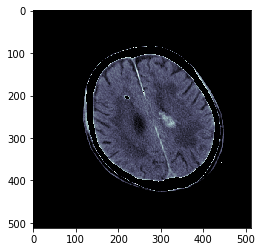

In [61]:
_=plt.imshow(px,cmap=plt.cm.bone)

KeyboardInterrupt: 

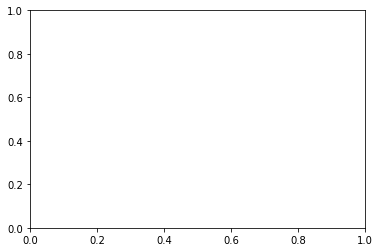

In [31]:
_=plt.hist(pixels,bins=30)

In [49]:
bits_df.to_csv(data_dir+'train_bits_df',index=False)

In [48]:
test_df = pd.read_csv(data_dir+'test.csv')


In [4]:
pids=np.unique(test_df.PatientID.values)

NameError: name 'test_df' is not defined

In [51]:
ar=np.zeros((test_df.shape[0],4),dtype=np.int)
fields=['BitsStored','PixelRepresentation','RescaleIntercept','RescaleSlope']
for i,pid in enumerate(tqdm_notebook(test_df.PatientID.values)):
    dcm_data = pydicom.dcmread(test_images_dir+'ID_{}.dcm'.format(pid))
    for j,field in enumerate(fields):
        ar[i,j]=int(dcm_data[field].value)
    

In [56]:
test_bits_df=pd.DataFrame(index=np.arange(test_df.shape[0]),columns=['PatientID','BitsStored','PixelRepresentation','RescaleIntercept','RescaleSlope'])

In [57]:
test_bits_df.PatientID=test_df.PatientID
test_bits_df[fields]=ar[:test_df.shape[0]]

In [59]:
test_bits_df[(test_bits_df.BitsStored==12) & (test_bits_df.PixelRepresentation==0) & (test_bits_df.RescaleIntercept>-999) ].shape

(0, 5)

In [33]:
pids=np.unique(train_df.PatientID.values)
k=0
for i,pid in enumerate(tqdm_notebook(pids)):
    dcm_data = pydicom.dcmread(train_images_dir+'ID_{}.dcm'.format(pid))
    try:
        pixels = np.array(dcm_data.pixel_array)
        if pixels.shape[0]!=pixels.shape[1]:
            k=k+1
            print('{} got unequale pid {} {} {}'.format(k,pid,pixels.shape[0],pixels.shape[1]))
    except:
        print('got some error with pid {}'.format(pid))
    


1 got unequale pid 038f966b9 408 374
1 got unequale pid 038f966b9 408 374
2 got unequale pid 04280250b 408 374
2 got unequale pid 04280250b 408 374
3 got unequale pid 046ba342c 638 490
3 got unequale pid 046ba342c 638 490
4 got unequale pid 0603b315e 408 374
4 got unequale pid 0603b315e 408 374
5 got unequale pid 079945c27 666 512
5 got unequale pid 079945c27 666 512
6 got unequale pid 081f4d071 408 374
6 got unequale pid 081f4d071 408 374
7 got unequale pid 0b0e59911 430 404
7 got unequale pid 0b0e59911 430 404
8 got unequale pid 0e1861e6d 638 490
8 got unequale pid 0e1861e6d 638 490
9 got unequale pid 0f8aa5749 408 374
9 got unequale pid 0f8aa5749 408 374
10 got unequale pid 10f34fb10 638 490
11 got unequale pid 10fe2031e 408 374
10 got unequale pid 10f34fb10 638 490
11 got unequale pid 10fe2031e 408 374
12 got unequale pid 12a0d6d34 430 404
12 got unequale pid 12a0d6d34 430 404
13 got unequale pid 12e3b6923 430 404
13 got unequale pid 12e3b6923 430 404
14 got unequale pid 17103c79e 

108 got unequale pid ba7080372 666 512
108 got unequale pid ba7080372 666 512
109 got unequale pid bb2a4a01c 430 404
109 got unequale pid bb2a4a01c 430 404
110 got unequale pid c037d5727 408 374
110 got unequale pid c037d5727 408 374
111 got unequale pid c07d2cb73 638 490
111 got unequale pid c07d2cb73 638 490
112 got unequale pid c1a3f037f 638 490
112 got unequale pid c1a3f037f 638 490
113 got unequale pid c35d5c858 430 404
113 got unequale pid c35d5c858 430 404
114 got unequale pid c45659d3d 666 512
115 got unequale pid c4575f13b 430 404
114 got unequale pid c45659d3d 666 512
115 got unequale pid c4575f13b 430 404
116 got unequale pid c964e4096 666 512
116 got unequale pid c964e4096 666 512
117 got unequale pid cbbb50e6d 666 512
117 got unequale pid cbbb50e6d 666 512
118 got unequale pid cec3997fa 638 490
118 got unequale pid cec3997fa 638 490
119 got unequale pid ced5fabca 408 374
119 got unequale pid ced5fabca 408 374
120 got unequale pid cef2af72d 638 490
120 got unequale pid cef2

In [13]:
bins=list(range(-3000,-600,100))+list(range(-500,500))+list(range(600,3000,100))
histb=np.zeros((pids.shape[0],len(bins)))
histv=np.zeros((pids.shape[0],len(bins)-1))
for i,pid in enumerate(tqdm_notebook(pids)):
    dcm_data = pydicom.dcmread(train_images_dir+'ID_{}.dcm'.format(pid))
    try:
        pixels = np.array(dcm_data.pixel_array)
        b = dcm_data.RescaleIntercept
        m = dcm_data.RescaleSlope
        pixels = m * pixels + b 
        histv[i],histb[i]=np.histogram(pixels,bins)
    except:
        print('got some error with pid {}'.format(pid))
        
    

got some error with pid 6431af929
got some error with pid e20bf3f8a
got some error with pid e20bf3f8a




In [14]:
hv=histv.mean(0)

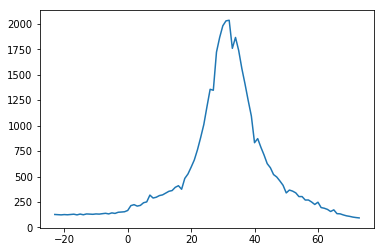

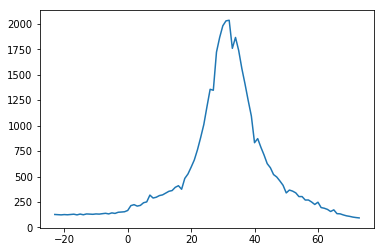

In [28]:
plt.plot(bins[501:-450],hv[500:-450])

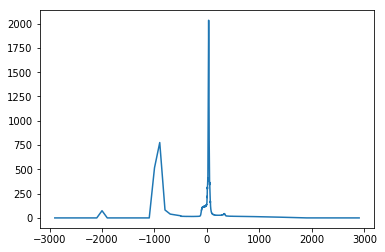

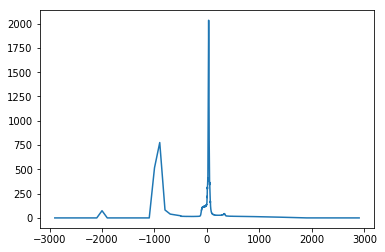

In [20]:
plt.plot(bins[1:],hv/(histb[0,1:]-histb[0,:-1]))

In [10]:
a=list(range(-3000,-600,100))+list(range(-500,500))+list(range(600,3000,100))

In [12]:
len(a)

1048

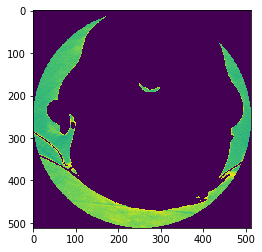

In [53]:
_=plt.imshow(a)

In [38]:
test_df = pd.read_csv(data_dir+'test.csv')
test_df.head(20)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819
5,04e46d29f,0.5,0.5,0.5,0.5,0.5,0.5,9af579ca67,1040f41a,13d6290b4c,30,80,113.380000,-125.0,-105.667000
6,879027e8e,0.5,0.5,0.5,0.5,0.5,0.5,cd38af45ad,be853d87,87c08af048,30,80,133.277000,-125.0,-102.641000
7,4428a1084,0.5,0.5,0.5,0.5,0.5,0.5,fe05a10ae6,fd165f70,cbc35ac142,30,80,150.295000,-125.0,-116.187000
8,1dccedf60,0.5,0.5,0.5,0.5,0.5,0.5,8257edc0f8,8a25d4eb,13d633652e,30,80,180.582199,-125.0,-83.197983
9,664216ec8,0.5,0.5,0.5,0.5,0.5,0.5,30df97244b,9115a389,99baf2ddbb,30,80,22.063042,-125.0,-117.330185


In [37]:
pickle_file=open(outputs_dir+'test_order','wb')
pickle.dump(test_df.PatientID.values,pickle_file,protocol=4)
pickle_file.close()


In [36]:
outputs_dir

'/media/hd/notebooks/data/RSNA/outputs/'

In [4]:
train_df.StudyI.unique().shape
train_df.PID.unique().shape
train_df.SeriesI.unique().shape


(19530,)

(17079,)

(19530,)

In [16]:
dd=train_df.sort_values(['SeriesI','ImagePositionZ'])
dd.head(10)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
540072,76d55d9d0,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,46.633,-125.0,-147.231
337482,96d282ea9,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,49.155,-125.0,-147.231
521793,7d8a7c29d,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,51.676,-125.0,-147.231
390644,4d4401491,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,54.198,-125.0,-147.231
457956,8f5ded0b7,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,56.719,-125.0,-147.231
624959,213346b48,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,59.241,-125.0,-147.231
409473,e07862283,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,61.762,-125.0,-147.231
489289,c29529650,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,64.284,-125.0,-147.231
209861,1bc422f0c,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,66.805,-125.0,-147.231
156061,73bf91129,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,69.327,-125.0,-147.231


In [20]:
dd['PatientID-1']=np.where(dd['StudyI']==dd['StudyI'].shift(1),np.roll(dd.index.values,1),-1)
dd['PatientID+1']=np.where(dd['StudyI']==dd['StudyI'].shift(-1),np.roll(dd.index.values,-1),-1)
dd.head(50)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY,PatientID-1,PatientID+1
540072,76d55d9d0,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,46.633000,-125.0,-147.231000,-1,337482
337482,96d282ea9,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,49.155000,-125.0,-147.231000,540072,521793
521793,7d8a7c29d,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,51.676000,-125.0,-147.231000,337482,390644
390644,4d4401491,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,54.198000,-125.0,-147.231000,521793,457956
457956,8f5ded0b7,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,56.719000,-125.0,-147.231000,390644,624959
624959,213346b48,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,59.241000,-125.0,-147.231000,457956,409473
409473,e07862283,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,61.762000,-125.0,-147.231000,624959,489289
489289,c29529650,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,64.284000,-125.0,-147.231000,409473,209861
209861,1bc422f0c,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,66.805000,-125.0,-147.231000,489289,156061
156061,73bf91129,0,0,0,0,0,0,b9797064,00b9e1961f,0000298a7d,30,80,69.327000,-125.0,-147.231000,209861,627593


In [24]:
a=np.random.randn(4,5)
a.shape[1:]
a
a[np.argsort(a[:,2])]

(5,)

array([[-1.09711871e+00, -4.73136538e-01, -4.89978341e-01,
        -1.26469773e+00, -2.44105720e-02],
       [-3.92241070e-01,  1.34374161e+00, -7.25791638e-01,
        -9.92744692e-01, -9.13586829e-01],
       [-5.59490746e-01,  9.97619634e-01,  1.24663298e+00,
        -3.14722181e+00,  2.11267159e-03],
       [ 4.96562767e-01,  2.24539492e-01,  2.16936474e+00,
        -2.64642558e-01, -6.59463385e-01]])

array([[-3.92241070e-01,  1.34374161e+00, -7.25791638e-01,
        -9.92744692e-01, -9.13586829e-01],
       [-1.09711871e+00, -4.73136538e-01, -4.89978341e-01,
        -1.26469773e+00, -2.44105720e-02],
       [-5.59490746e-01,  9.97619634e-01,  1.24663298e+00,
        -3.14722181e+00,  2.11267159e-03],
       [ 4.96562767e-01,  2.24539492e-01,  2.16936474e+00,
        -2.64642558e-01, -6.59463385e-01]])

In [29]:
split = train_df.SeriesI.unique()
np.random.seed(4356)
np.random.shuffle(split)
split_train=split[:int(0.9*split.shape[0])]
split_val=split[int(0.9*split.shape[0]):]

idx_train = train_df[train_df.SeriesI.isin(set(split_train))].index.values
idx_validate = train_df[train_df.SeriesI.isin(set(split_val))].index.values
idx_train.shape
idx_validate.shape

(606802,)

(67708,)

In [34]:
train_df[sub_types].values.mean(0)
train_df[sub_types].values[idx_train].mean(0)
train_df[sub_types].values[idx_validate].mean(0)


array([0.00409334, 0.04827801, 0.03523447, 0.04762272, 0.06300277,
       0.1439608 ])

array([0.00401614, 0.04836833, 0.03520918, 0.04757071, 0.0629843 ,
       0.14388713])

array([0.00478525, 0.04746854, 0.0354611 , 0.04808885, 0.06316831,
       0.14462102])

In [24]:
pid_train=set(train_df.PID.unique())
pid_test=set(test_df.PID.unique())

len(pid_test.difference(pid_train))
len(pid_test)

1859

2144

In [25]:
StudyI_train=set(train_df.StudyI.unique())
StudyI_test=set(test_df.StudyI.unique())

len(StudyI_test.difference(StudyI_train))
len(StudyI_test)

2214

2214

In [26]:
SeriesI_train=set(train_df.SeriesI.unique())
SeriesI_test=set(test_df.SeriesI.unique())

len(SeriesI_test.difference(SeriesI_train))
len(SeriesI_test)

2214

2214

In [21]:
pid_test

{'ID_768d04c1',
 'ID_0bd76fc9',
 'ID_b7f8035b',
 'ID_7d3954f7',
 'ID_f4f7a9a6',
 'ID_f04e7182',
 'ID_eb7ce28a',
 'ID_106d2f99',
 'ID_9feefc82',
 'ID_1007a7a1',
 'ID_6fae0725',
 'ID_3fb7f907',
 'ID_6e61e4ee',
 'ID_6d1719c9',
 'ID_66add97b',
 'ID_38530d54',
 'ID_19978323',
 'ID_c7a8c320',
 'ID_02584b75',
 'ID_c1db6e2e',
 'ID_5942ad9f',
 'ID_a5a3c928',
 'ID_3273572b',
 'ID_bd3b7c1c',
 'ID_74a55775',
 'ID_673f9f50',
 'ID_108d13d8',
 'ID_d304458a',
 'ID_7d7a48f6',
 'ID_7ed4a54f',
 'ID_d9b2f3d6',
 'ID_0c59c5e1',
 'ID_2d899c43',
 'ID_ffd4ab30',
 'ID_b9b224f0',
 'ID_8a7d528a',
 'ID_0e71279b',
 'ID_b799ed34',
 'ID_e830ae0e',
 'ID_f45f1f47',
 'ID_a8fc5924',
 'ID_6213397b',
 'ID_0662001f',
 'ID_ee83d065',
 'ID_9723f40a',
 'ID_a4daebb9',
 'ID_b628ef4e',
 'ID_102c1abd',
 'ID_b2fa61be',
 'ID_fb4512ab',
 'ID_ba7bd136',
 'ID_d54f5eff',
 'ID_f4a19083',
 'ID_d9ece8ef',
 'ID_93062e96',
 'ID_6dc6a04b',
 'ID_6d963ed0',
 'ID_eab14924',
 'ID_bb1c6d36',
 'ID_382a6911',
 'ID_95779b88',
 'ID_ad84de2a',
 'ID_55b

In [20]:
gp = train_df[['PatientID','SeriesI']].groupby('SeriesI').count().reset_index()
gp.head()

,SeriesI,PatientID
0,0000298a7d,40
1,0004c4e54c,28
2,000a935543,32
3,000f6fd7db,32
4,001231935f,29


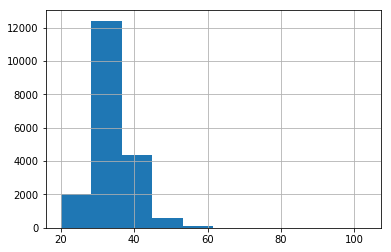

In [21]:
gp.PatientID.hist()


In [6]:
train_df[train_df['any']==1].head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI
14,aeda0804d,0,0,0,0,1,1,af8ac3ec,81a154bf08,619b3f95fe
36,5fc337950,0,0,0,1,0,1,96bb7e1d,4b827bde69,fcc1430f1b
44,4f4c47ae0,0,1,1,0,0,1,4e18b534,e7cc0d0589,c086ead69b
66,fb4205b7f,0,0,0,1,1,1,d256ade0,eb89b76b13,982bec9d61
69,789fcc41a,0,0,0,0,1,1,a1779669,1bdf3d30e3,aff99b7850


In [29]:
train_df[['epidural','intraparenchymal','intraventricular','subarachnoid','subdural','any']].mean(0)

epidural            0.004093
intraparenchymal    0.048278
intraventricular    0.035234
subarachnoid        0.047623
subdural            0.063003
any                 0.143961
dtype: float64

In [189]:
hem_types=['epidural','intraparenchymal','intraventricular','subarachnoid','subdural','any']
for h in hem_types: 
    r1=train_df[train_df[h]==1].SeriesI.unique().shape[0]/train_df.SeriesI.unique().shape[0]
    r2=train_df[train_df[h]==1].shape[0]/train_df.shape[0]
    print(h,r1,r2)

epidural 0.016026625704045058 0.004093341833330862
intraparenchymal 0.24557091653865848 0.04827800922150895
intraventricular 0.16963645673323094 0.03523446650160857
subarachnoid 0.1817204301075269 0.047622718714325954
subdural 0.17624167946748592 0.063002772382915
any 0.40977982590885814 0.1439608011741857


In [203]:
np.argwhere(~(train_df[hem_types].values[None].sum(axis=1)>0)).squeeze()

array([], shape=(0, 2), dtype=int64)

In [210]:
a=Ellipsis
train_df[hem_types].values[a].shape

(674510, 6)

In [211]:
s=sampler(train_df[hem_types].values,0.2,[10,1,1,1,1,0])

In [216]:
train_df[hem_types].values[s()].mean(0)

(577407,)
(134902,)
(27610,)
(32564,)
(23766,)
(32122,)
(42496,)


array([0.10056226, 0.21332379, 0.15566346, 0.20623935, 0.22965992,
       0.54030532])

In [184]:
a={'yes':7,'high':8}
tq = tqdm_notebook(range(10))
for i in tq:
    tq.set_postfix(**a)
    

In [187]:
a=torch.tensor([1,2,3,4])
a.repeat(5,1)

tensor([[1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4]])

In [186]:
a

{'yes': 7, 'high': 8, 'f': 6}

In [88]:
train_df[hem_types].values[inx].mean(0)

array([0.09019668, 0.19133518, 0.13961826, 0.18498097, 0.20598744,
       0.48461268])

In [86]:
np.unique(inx).shape[0]/inx.shape[0]

0.6124131232735024

In [8]:
a=np.arange(24).reshape((2,3,4))
a.ndim
a.size

3

24

In [20]:
slice(None)

slice(None, None, None)

In [31]:
for k,(i, j) in enumerate(zip([1,2,3],[4,6,7])):
    print (k,i,j)

0 1 4
1 2 6
2 3 7


In [ ]:
indx = [Ellipsis]*myarray.ndim
indx[slice_dim] = i
slice = myarray[indx]

In [20]:
train_df[train_df.SeriesI=='fcc1430f1b'].head(40)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
36,5fc337950,0,0,0,1,0,1,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,107.5,-126.408875,-126.408875
9093,88d342977,0,0,0,0,0,0,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,142.5,-126.408875,-126.408875
31908,69a4c5b80,0,0,0,0,0,0,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,7.5,-126.408875,-126.408875
73401,60b3d5a8f,0,0,0,1,0,1,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,62.5,-126.408875,-126.408875
112916,c5ff305fe,0,0,0,0,0,0,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,122.5,-126.408875,-126.408875
119820,655805e68,0,0,0,0,0,0,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,152.5,-126.408875,-126.408875
125421,61c30c348,0,0,0,1,0,1,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,92.5,-126.408875,-126.408875
142226,2d2343b13,0,0,0,1,0,1,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,67.5,-126.408875,-126.408875
144573,6b2f97d02,0,0,0,1,0,1,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,72.5,-126.408875,-126.408875
156212,1f4704866,0,0,0,0,0,0,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,12.5,-126.408875,-126.408875


IndexError: index 32 is out of bounds for axis 0 with size 32

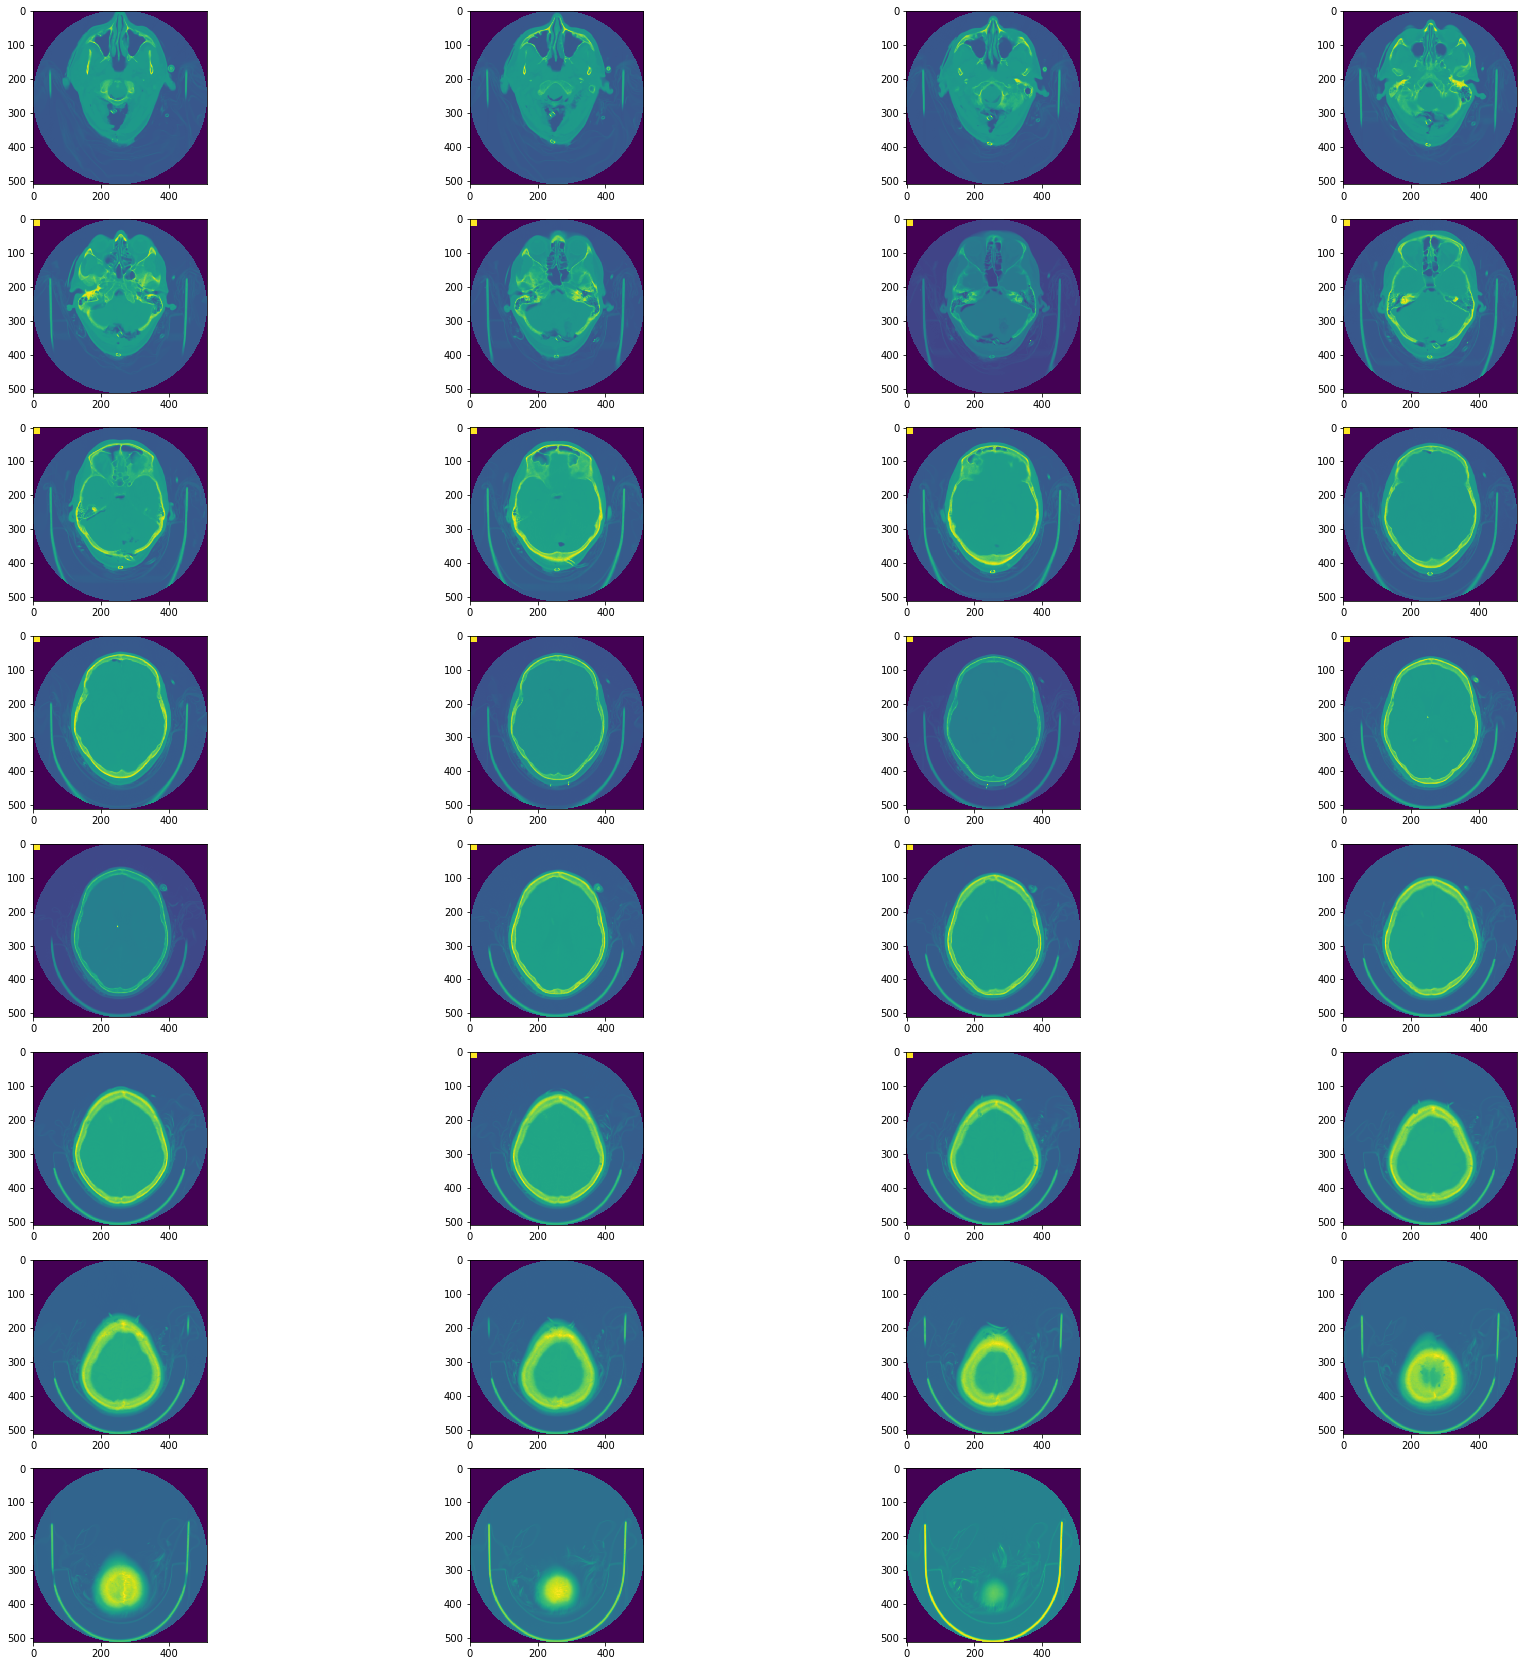

In [27]:
fig=plt.figure(figsize=(30, 30))
columns = 4; rows = 8
patient1=train_df[train_df.SeriesI=='982bec9d61'].copy().sort_values(by=['ImagePositionZ'])
pid=patient1.PatientID.values
for i in range(1, columns*rows +1):
    pixels = load_one_image(pid[i])
    if train_df[train_df.PatientID==pid[i]]['any'].values[0]>0:
        pixels[:20,:20]=pixels.max()
    _=fig.add_subplot(rows, columns, i)
    if pixels.max()==pixels.min():
        break
    _=plt.imshow(pixels)
    _=fig.add_subplot

In [60]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [18]:
%matplotlib nbagg


def __plot(fig,ax,arr):
    _=ax.clear()
    _=ax.plot(arr)
    _=ax.set_xlabel('batch')
    _=ax.set_ylabel('loss')
    _=fig.canvas.draw()

<IPython.core.display.Javascript object>


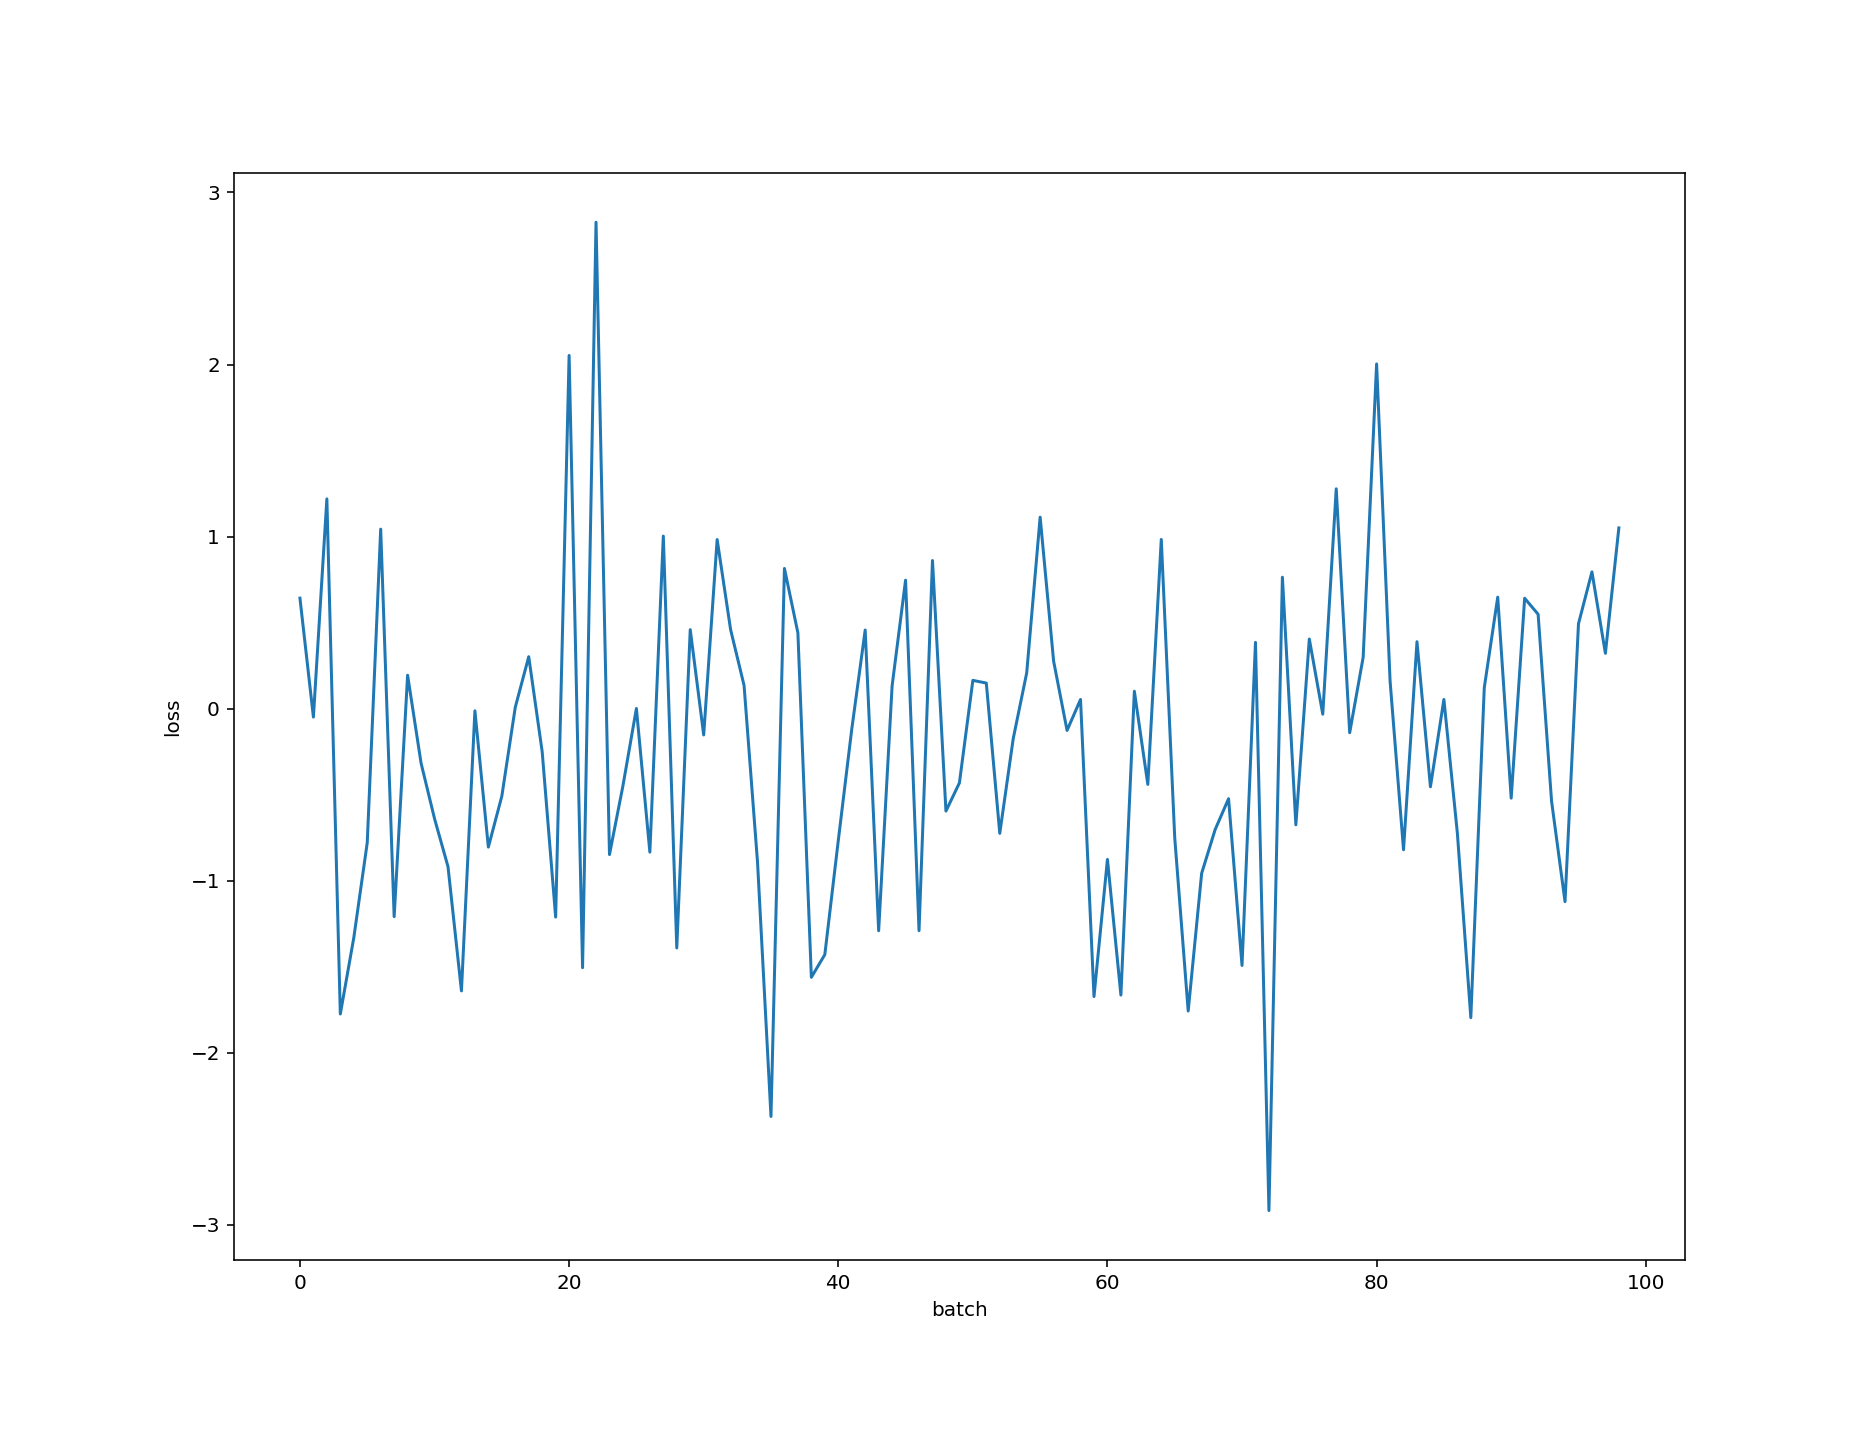

In [20]:
m =100
n=100
matrix=np.random.normal(0,1,m*n).reshape(m,n)
fig, ax = plt.subplots(figsize=(13,10))
#fig = plt.figure()
#ax = fig.add_subplot(111)
#_=plt.ion()
#_=fig.show()
#_=fig.canvas.draw()
for i in range(0,100):
    __plot(fig,ax,matrix[0,:i])

In [ ]:
class loss_graph():
    def __init__(self,fig,ax,num_epoch=1,batch2epoch=100):
        self.num_epoch=num_epoch
        self.batch2epoch=batch2epoch
        self.loss_arr=np.zeros(num_epoch*batch2epoch,dtype=np.float)
        self.arr_size=num_epoch*batch2epoch
        self.num_points=0
        self.fig=fig
        self.ax = ax
        self.ticks = (np.arange(0, num_epoch*batch2epoch+1, step=batch2epoch),np.arange(0, num_epoch+1, step=1))
    def __call__(self,loss):
        if self.num_points==self.arr_size:
            new_arr=np.zeros(self.arr_size+self.batch2epoch,dtype=np.float)
            new_arr[:self.arr_size]=self.loss_arr
            self.loss_arr=new_arr
        self.loss_arr[self.num_points]=loss
        self.num_points=self.num_points+1
        _=self.ax.clear()
        _=self.ax.plot(self.loss_arr[0:self.num_points])
        _=self.ax.set_xlabel('batch')
        _=self.ax.set_ylabel('loss')
        _=plt.xticks(self.ticks[0],self.ticks[1])
        _=self.fig.canvas.draw()

<IPython.core.display.Javascript object>


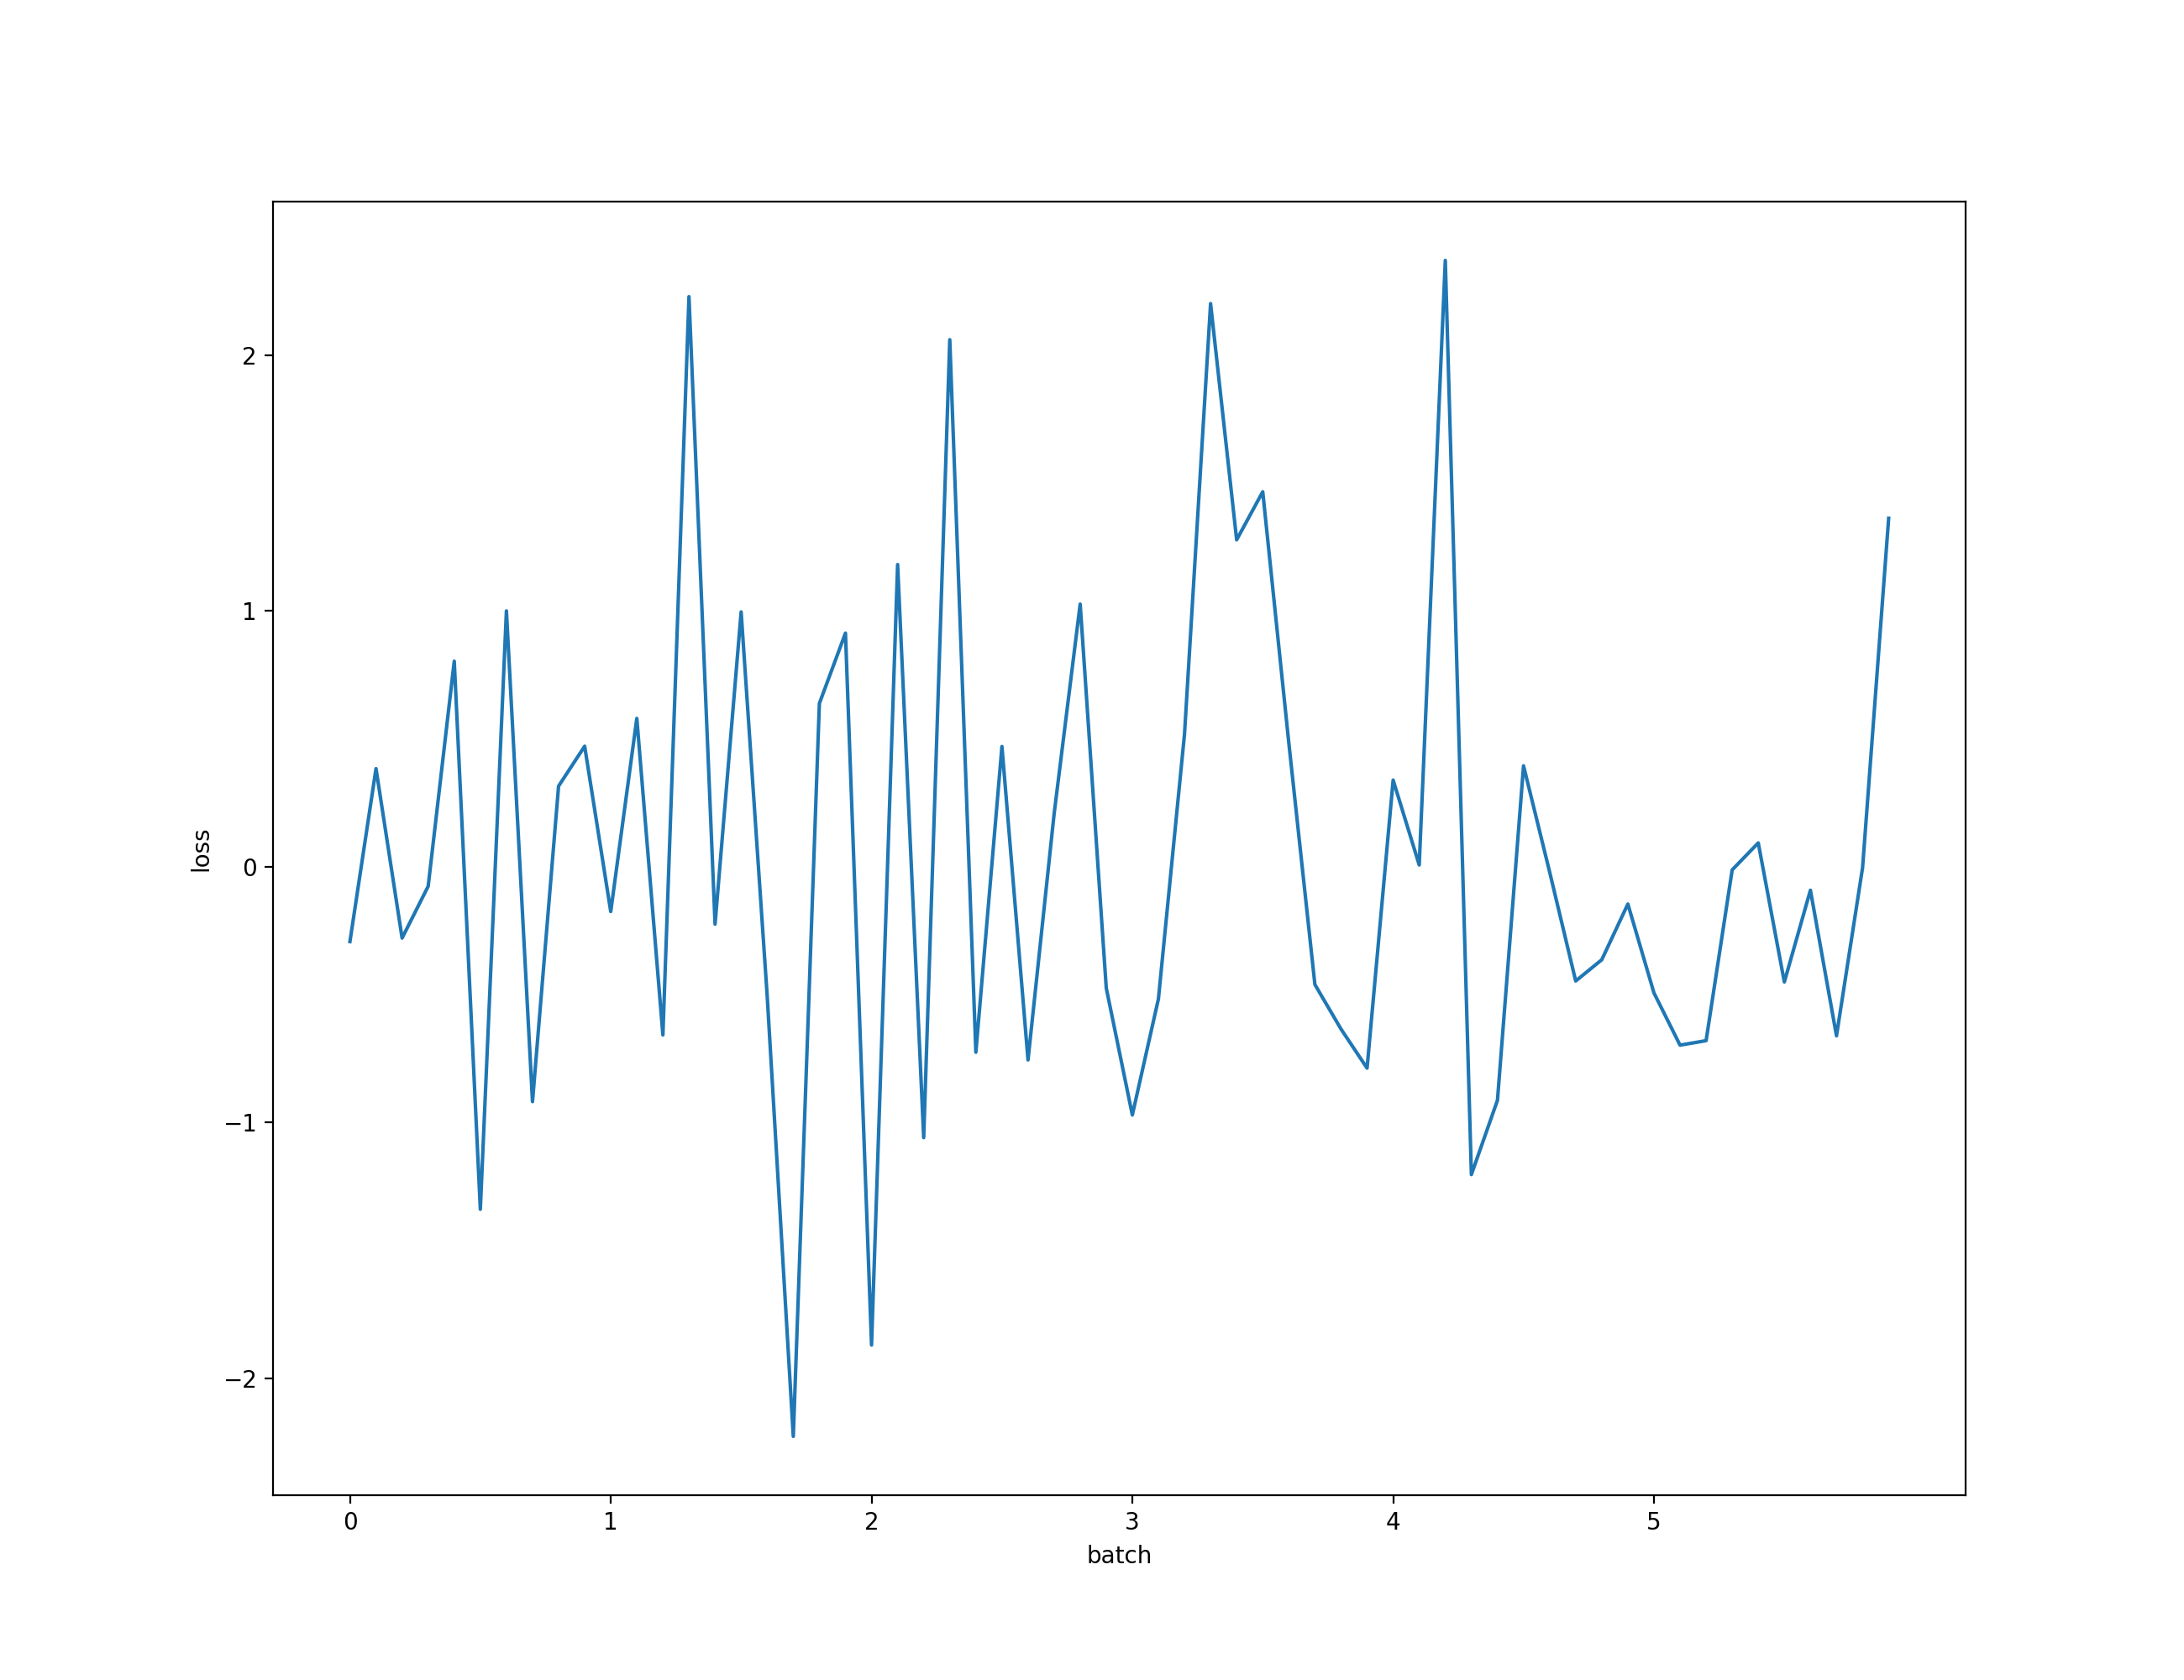

In [17]:
fig,ax = plt.subplots(figsize=(13,10))
gr=loss_graph(fig,ax,5,10)
for i in range(60):
    gr(np.random.randn(1))

In [28]:
PID = np.zeros(train_df.shape[0],dtype=object)
StudyI = np.zeros(train_df.shape[0],dtype=object)
SeriesI = np.zeros(train_df.shape[0],dtype=object)

for i,row in tqdm_notebook(train_df.iterrows(),total=train_df.shape[0]):
    ds = pydicom.dcmread(train_images_dir + 'ID_{}.dcm'.format(row['PatientID']))
    SeriesI[i]=ds.SeriesInstanceUID
    PID[i]=ds.PatientID
    StudyI[i]=ds.StudyInstanceUID    
train_df.SeriesI=SeriesI
train_df.PID=PID
train_df.StudyI=StudyI

In [16]:
WindowCenter = np.zeros(train_df.shape[0],dtype=object)
WindowWidth = np.zeros(train_df.shape[0],dtype=object)
ImagePositionX = np.zeros(train_df.shape[0],dtype=np.float)
ImagePositionY = np.zeros(train_df.shape[0],dtype=np.float)
ImagePositionZ = np.zeros(train_df.shape[0],dtype=np.float)
for i,row in tqdm_notebook(train_df.iterrows(),total=train_df.shape[0]):
    ds = pydicom.dcmread(train_images_dir + 'ID_{}.dcm'.format(row['PatientID']))
    WindowCenter[i]=ds.WindowCenter
    WindowWidth[i]=ds.WindowWidth
    ImagePositionX[i]=float(ds.ImagePositionPatient[0])
    ImagePositionY[i]=float(ds.ImagePositionPatient[1])
    ImagePositionZ[i]=float(ds.ImagePositionPatient[2])
train_df['WindowCenter']=WindowCenter
train_df['WindowWidth']=WindowWidth
train_df['ImagePositionZ']=ImagePositionZ
train_df['ImagePositionX']=ImagePositionX
train_df['ImagePositionY']=ImagePositionY


In [15]:
ds

(0008, 0018) SOP Instance UID                    UI: ID_63eb1e259
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_a449357f'
(0020, 000d) Study Instance UID                  UI: ID_62d125e5b2
(0020, 000e) Series Instance UID                 UI: ID_0be5c0d1b3
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '-8', '180.199951']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '1', '0']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 12
(0028, 0102) High Bit  

In [31]:
train_df.SeriesI = train_df.SeriesI.str.split("_", expand = True)[1]
train_df.PID = train_df.PID.str.split("_", expand = True)[1]
train_df.StudyI = train_df.StudyI.str.split("_", expand = True)[1]

In [24]:
row['PatientID']

TypeError: tuple indices must be integers or slices, not str

In [22]:
row

(0, PatientID           63eb1e259
 epidural                    0
 intraparenchymal            0
 intraventricular            0
 subarachnoid                0
 subdural                    0
 any                         0
 PID                         0
 StudyI                      0
 SeriesI                     0
 Name: 0, dtype: object)

In [36]:
train_df.isnull().sum()

PatientID           0
epidural            0
intraparenchymal    0
intraventricular    0
subarachnoid        0
subdural            0
any                 0
dtype: int64

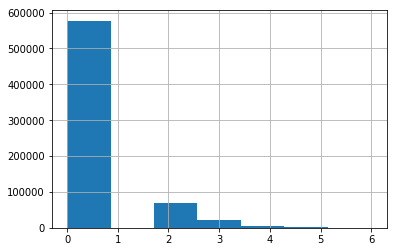

In [39]:
train_df[sub_types].sum(1).hist(bins=7)

In [12]:
pid=train_df[train_df.SeriesI=='fcc1430f1b'].PatientID.values
for i in pid[:5]:
    ds = pydicom.dcmread(train_images_dir + 'ID_{}.dcm'.format(i))
    print(ds)

(0008, 0018) SOP Instance UID                    UI: ID_5fc337950
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_96bb7e1d'
(0020, 000d) Study Instance UID                  UI: ID_4b827bde69
(0020, 000e) Series Instance UID                 UI: ID_fcc1430f1b
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-126.408875', '-126.408875', '107.500000']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '1.000000', '0.000000']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.494750976563', '0.494750976563']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) 

In [9]:
ds.WindowCenter

"122.500000"

In [65]:
pydicom.dcmread(train_images_dir + 'ID_{}.dcm'.format(train_df['PatientID'].values[1119]))

(0008, 0018) SOP Instance UID                    UI: ID_ec64a23d9
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_a3bb8ef1'
(0020, 000d) Study Instance UID                  UI: ID_7fb7923740
(0020, 000e) Series Instance UID                 UI: ID_798981a032
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '-11', '223.800049']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '1', '0']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 12
(0028, 0102) High Bit 

In [143]:
def window_img(dcm, width=None, level=None):
    pixels = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    if not width:
        width = dcm.WindowWidth
        if type(width) != pydicom.valuerep.DSfloat:
            width = width[0]
    if not level:
        level = dcm.WindowCenter
        if type(level) != pydicom.valuerep.DSfloat:
            level = level[0]
    lower = level - (width / 2)
    upper = level + (width / 2)
    return np.clip(pixels, lower, upper)

def load_one_image(pid,mid=True ,width=None, level=None,file_path='/media/nvme/data/RSNA/stage_1_train_images/'):
    dcm_data = pydicom.dcmread(train_images_dir + 'ID_{}.dcm'.format(pid))
    pixels = dcm_data.pixel_array
    mx=pixels.max()
    mn=pixels.min()
    #pixels=(pixels-mn)*255/(mx-mn)
    if mid:
        pixels=(pixels-pixels[128:384,128:384].mean())/pixels[128:384,128:384].std()*1000
    else:
        pixels=(pixels-pixels.mean())/pixels.std()*1000
        
    return pixels

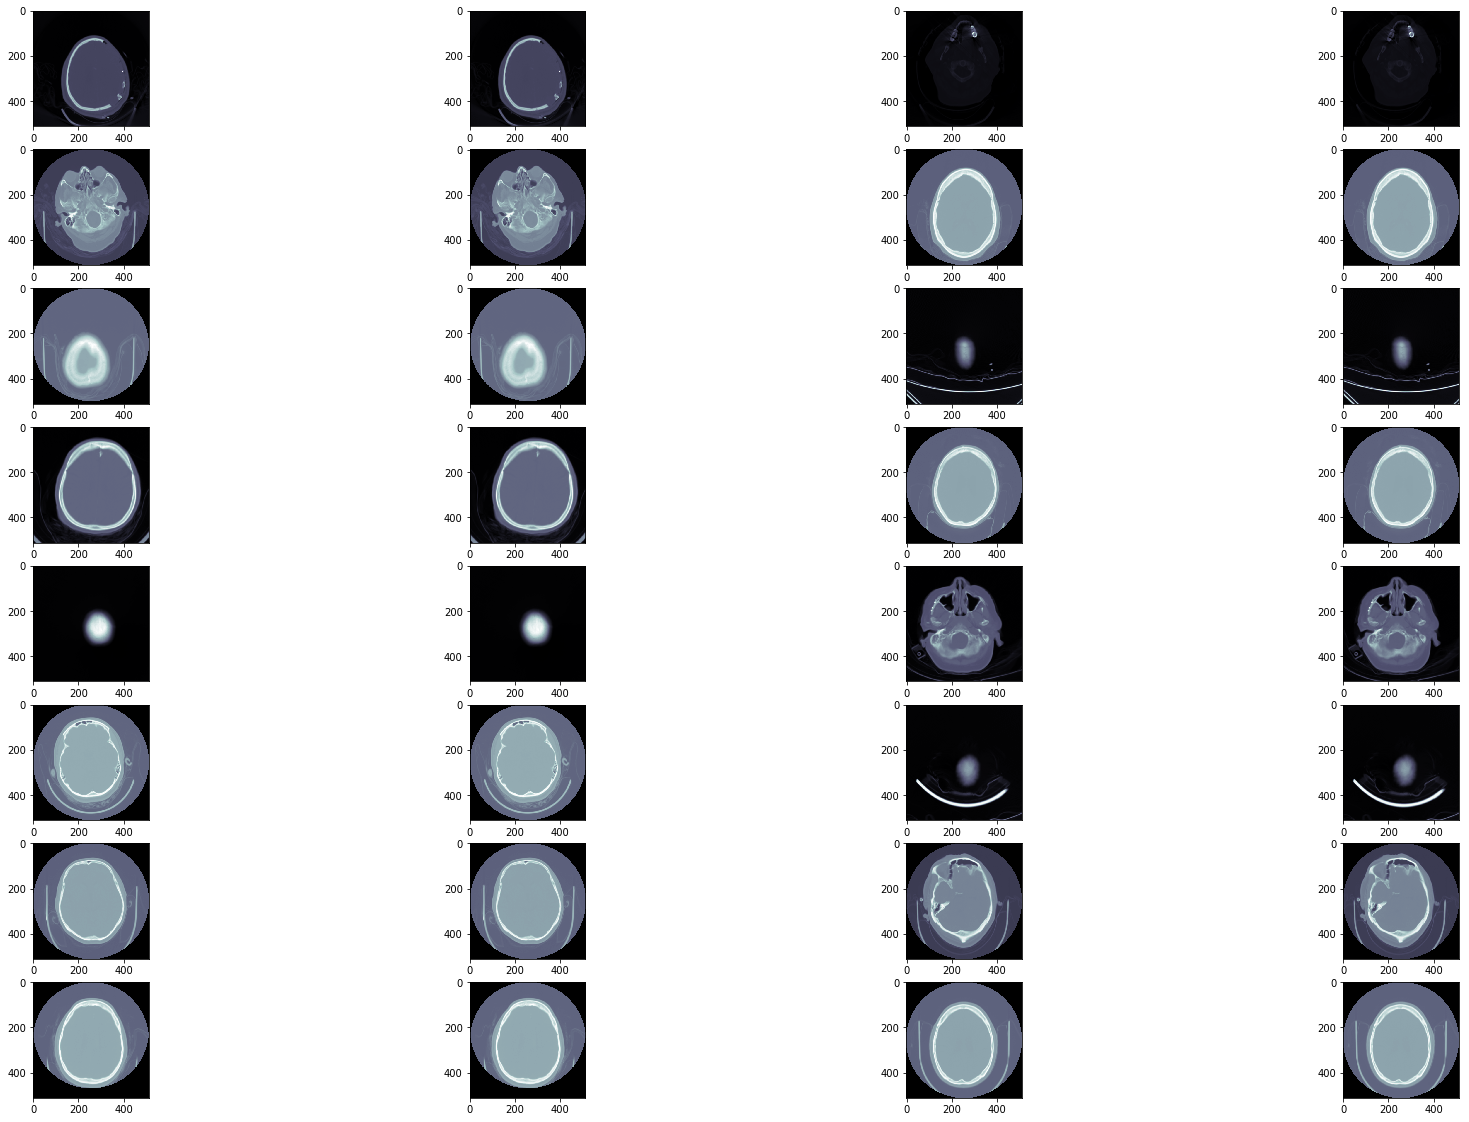

In [147]:
train_ids=train_df['PatientID'].sample(100).values
fig=plt.figure(figsize=(30, 20))
columns = 4; rows = 8
for i in range(1, columns*rows +1):
    pixels = load_one_image(train_ids[(i-1)//2],mid=(i%2==0))
    fig.add_subplot(rows, columns, i)
    if pixels.max()==pixels.min():
        break
    plt.imshow(pixels, cmap=plt.cm.bone)
    fig.add_subplot

In [77]:
a=(((pixels-pixels.min())*255/(pixels.max()-pixels.min())).astype(np.int))
a.min()

0

In [134]:
pixels = load_one_image(train_df.PatientID.values[2],equlize=True)

TypeError: load_one_image() got an unexpected keyword argument 'equlize'

In [145]:
#train_path='stage_1_train_images/'
#test_path='stage_1_test_images/'
#file_format='ID_{}.dcm'
dcm_data = pydicom.dcmread('/media/nvme/data/RSNA/'+'stage_1_train_images/'+ file_format.format(train_df.PatientID.values[2]))

In [136]:
pixels = dcm_data.pixel_array

In [147]:
def in_window(dcm_data):
    pixels = dcm_data.pixel_array
    c = int(dcm_data.WindowCenter[0] if type(dcm_data.WindowCenter) == pydicom.multival.MultiValue else dcm_data.WindowCenter)
    w = int(dcm_data.WindowWidth[0] if type(dcm_data.WindowWidth) == pydicom.multival.MultiValue else dcm_data.WindowWidth)
    #    c = 40
    #    w = 80
    b = dcm_data.RescaleIntercept
    m = dcm_data.RescaleSlope
    x = m * pixels + b
    return ((x > (c - 0.5 - (w - 1) / 2)) & (x <= (c - 0.5 + (w - 1) / 2))).any()

In [150]:
ids = train_df.PatientID.values[:10000]
anys = train_df['any'].values[:10000]
tq = tqdm_notebook(ids)
in_arr=np.zeros(ids.shape[0],np.bool)
k=0
a=0
for i,id_ in enumerate(tq):
    in_arr[i]= in_window(pydicom.dcmread('/media/nvme/data/RSNA/'+'stage_1_train_images/'+ file_format.format(id_)))
    k = k + int(~in_arr[i])
    a = a + int((~in_arr[i]) & (anys[i]) )
    if (~in_arr[i]) & (anys[i]):
        print (id_)
    tq.set_postfix(k=k,a=a)

In [ ]:
huston is the an empty picture b684a751d
huston is the an empty picture 2e7c2cefe
huston is the an empty picture 199e37bc5
huston is the an empty picture 228358483
huston is the an empty picture 7dfd1378f
huston is the an empty picture 98bd08520
huston is the an empty picture 673a9f882
huston is the an empty picture aba98e702
huston is the an empty picture da54e1fe5

In [107]:
pixels = load_one_image('da54e1fe5',equalize=False,window_eq=3)
pixels1 = load_one_image('da54e1fe5',equalize=False,window_eq=False)

In [15]:
train_df[train_df['any']==1].head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
14,aeda0804d,0,0,0,0,1,1,af8ac3ec,81a154bf08,619b3f95fe,40,150,114.88500,-125.000000,-119.215000
36,5fc337950,0,0,0,1,0,1,96bb7e1d,4b827bde69,fcc1430f1b,35.000000,135.000000,107.50000,-126.408875,-126.408875
44,4f4c47ae0,0,1,1,0,0,1,4e18b534,e7cc0d0589,c086ead69b,40,150,-9.00000,-125.000000,-125.000000
66,fb4205b7f,0,0,0,1,1,1,d256ade0,eb89b76b13,982bec9d61,40,150,36.61200,-125.000000,-100.967000
69,789fcc41a,0,0,0,0,1,1,a1779669,1bdf3d30e3,aff99b7850,30,80,143.19812,-125.000000,-97.797981


In [59]:
df.iloc[131]
df.iloc[14]

PatientID                    7917e32fe
epidural                             0
intraparenchymal                     0
intraventricular                     0
subarachnoid                         0
subdural                             1
any                                  1
PID                           27ddc408
StudyI                      1d872d37c6
SeriesI                     a9305e42cd
WindowCenter        ['00100', '00100']
WindowWidth         ['00600', '00600']
ImagePositionZ                     333
ImagePositionX                -114.184
ImagePositionY                 49.6053
Name: 131, dtype: object

PatientID            aeda0804d
epidural                     0
intraparenchymal             0
intraventricular             0
subarachnoid                 0
subdural                     1
any                          1
PID                   af8ac3ec
StudyI              81a154bf08
SeriesI             619b3f95fe
WindowCenter                40
WindowWidth                150
ImagePositionZ         114.885
ImagePositionX            -125
ImagePositionY        -119.215
Name: 14, dtype: object

In [5]:
k=14
pixels = load_one_image(df.PatientID.values[k],rescale=False)
dcm = pydicom.dcmread('/media/nvme/data/RSNA/'+'stage_1_train_images/'+ file_format.format(df.PatientID.values[k]))
#pixels1 = load_one_image(train_df.PatientID.values[5],equalize=False,window_eq=False)

NameError: name 'df' is not defined

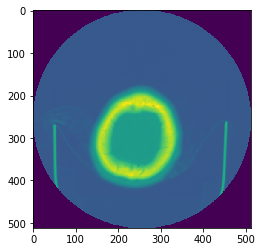

In [64]:
plt.imshow(pixels)

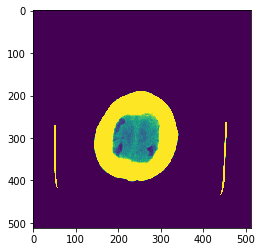

In [65]:
p = dcm_window(dcm,pixels,window = (40,80))
plt.imshow(p)

In [131]:
pixels.min(),pixels.max(),pixels.mean(),pixels.std()
pixels1.min(),pixels1.max(),pixels1.mean(),pixels1.std()

(-0.9999999999878006, 2.0, -0.46756187087112827, 0.9088902695866701)

(0, 4000, 467.5340156555176, 563.8710062580492)

In [44]:
pickle_file=open('/media/hd/notebooks/data/RSNA/outputs/model_Densenet161_3_vehrsion_basic_classifier_neighbors2_type_predictions_train_split_2.pkl','rb')
pred=pickle.load(pickle_file)
pickle_file.close()


In [46]:
pred.shape
df=train_df[~train_df.PatientID.isin(['e20bf3f8a','8da38f2e4','6431af929','470e639ae','0e21abf7a','d91d52bdc'])]
df.shape

torch.Size([674504, 6])

(674504, 15)

In [68]:
p=np.where((pred[:,-1].numpy()<0.1) & (df['any'].values==1) )[0]

array([    14,    131,    133, ..., 674313, 674432, 674456])

In [90]:
hemorrhage_types=['epidural','intraparenchymal','intraventricular','subarachnoid','subdural','any']
p=np.where((pred[:,-1].numpy()<0.1) & (df['any'].values==1) )[0]
df[hemorrhage_types].values[p].sum(0)/df[hemorrhage_types].values.sum(0)
p=np.where((pred[:,-1].numpy()>0.3) & (df['any'].values==0) )[0]
(pred[p].numpy()>0.3).sum(0)/(df[hemorrhage_types].values==0).sum(0)

array([0.16008693, 0.08125537, 0.06046453, 0.17156466, 0.19667733,
       0.17737866])

array([5.50805889e-05, 1.32878462e-03, 9.74278435e-04, 1.68124263e-03,
       4.84962216e-03, 1.36716078e-02])

In [86]:
p
df[hemorrhage_types].values[p]

array([ True,  True,  True, ...,  True,  True, False])

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [20]:
m = max(pixels.shape)
p = np.ones((m,m))*pixels[0,0]
p[(m-pixels.shape[0])//2:(m-pixels.shape[0])//2+pixels.shape[0],
  (m-pixels.shape[1])//2:(m-pixels.shape[1])//2+pixels.shape[1]]=pixels
pixels = p

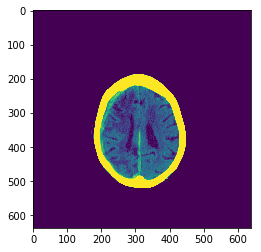

In [21]:
plt.imshow(pixels)

In [4]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [31]:
k=0
pixels = load_one_image(train_df.PatientID.values[k],rescale=False)
dcm = pydicom.dcmread('/media/nvme/data/RSNA/'+'stage_1_train_images/'+ file_format.format(train_df.PatientID.values[k]))

In [34]:
transform=MyTransform(mean_change=15,
                      std_change=0,
                      flip=True,
                      zoom=(0.2,0.2),
                      rotate=30,
                      out_size=512,
                      shift=10,
                      normal=False)

#transform=MyTransform(out_size=384)

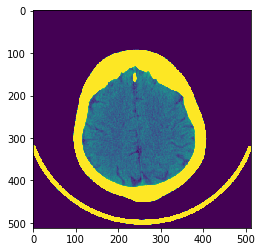

In [33]:
_=plt.imshow(dcm_window(dcm,pixels,window = (40,80)))

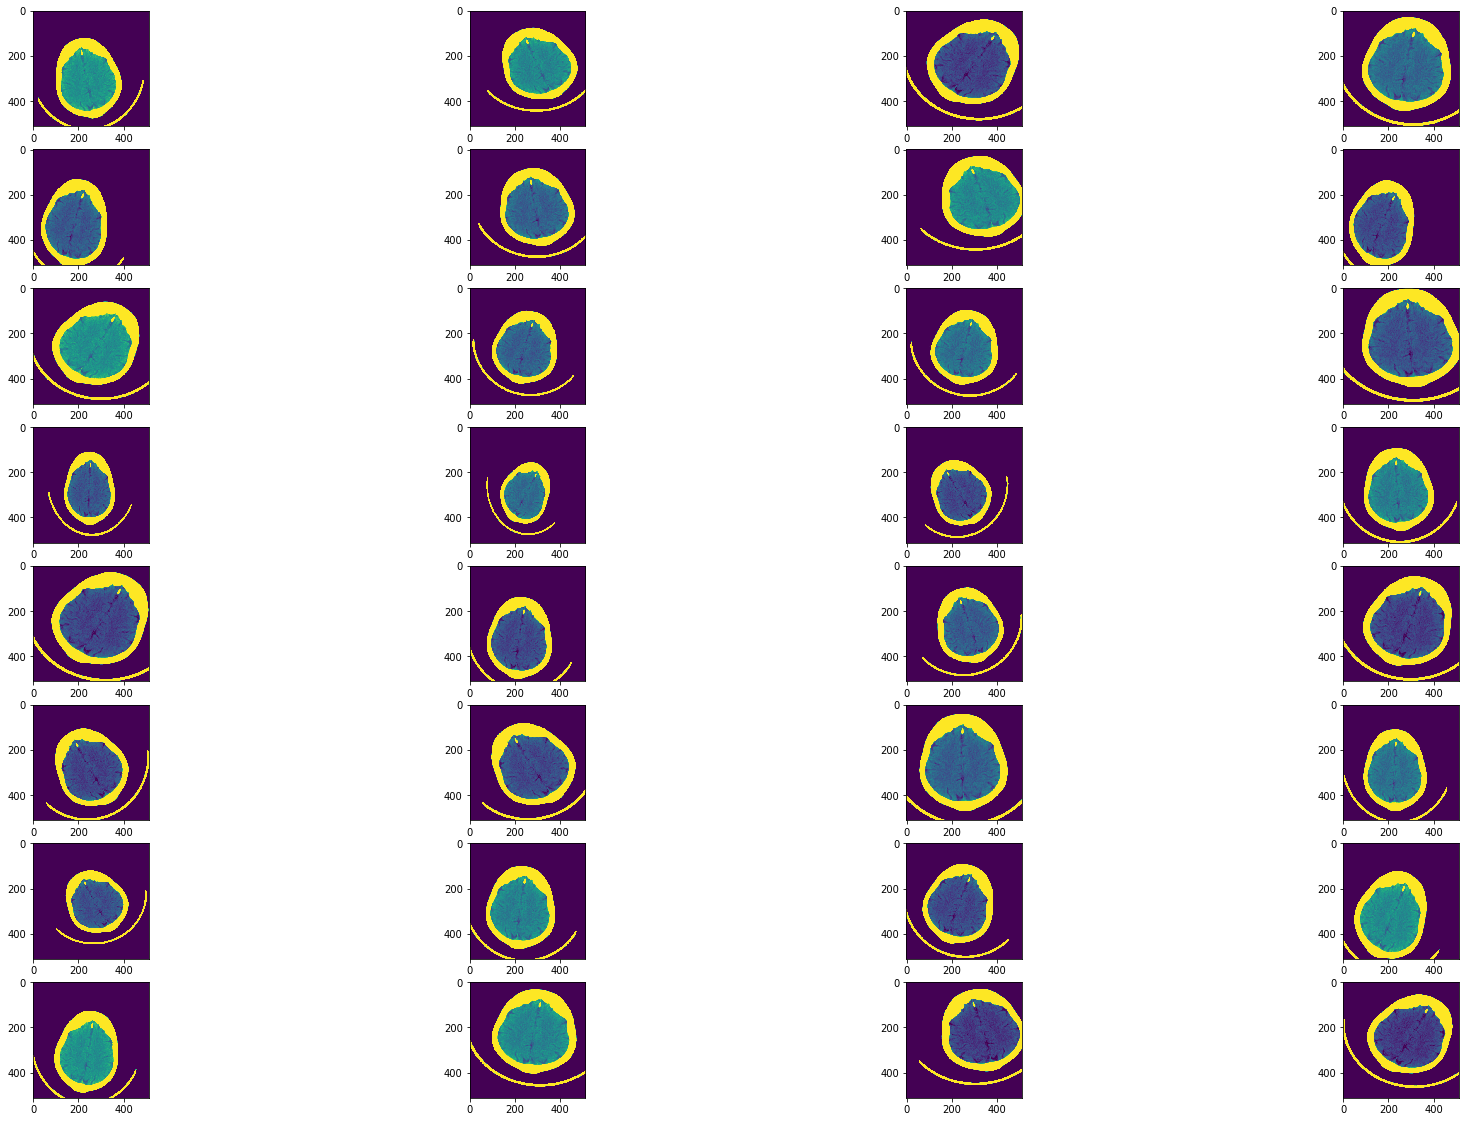

In [35]:
fig=plt.figure(figsize=(30, 20))
columns = 4; rows = 8
for i in range(1, columns*rows +1):
    pix=transform.random(pixels)
    pix=dcm_window(dcm,pix,window = (40,80))
    _=fig.add_subplot(rows, columns, i)
    _=plt.imshow(pix)
    _=fig.add_subplot

In [66]:
pix[200,200]


30.170204169421943

1393.4128071191308

In [53]:
a=torch.ones(24).reshape(3,2,4).to(torch.float)
b = torch.tensor([1.,2.,3.])
(a.transpose(0,-1)*b).transpose(0,-1)


tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[2., 2., 2., 2.],
         [2., 2., 2., 2.]],

        [[3., 3., 3., 3.],
         [3., 3., 3., 3.]]])

In [92]:
alpha=0.4
a=np.random.beta(alpha, alpha, 64)
#np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
a[:,None].shape

(64, 1)

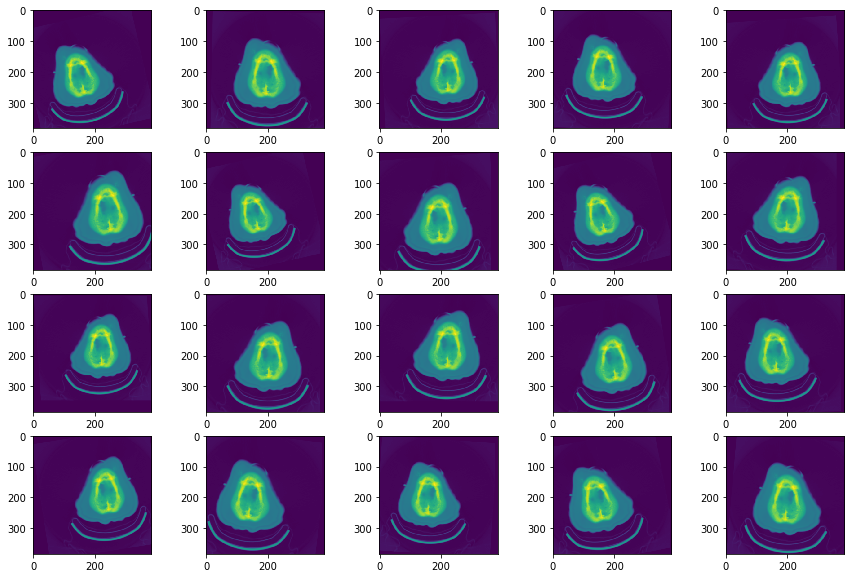

In [44]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    _=fig.add_subplot(rows, columns, i)
    if pixels.max()==pixels.min():
        break
    _=plt.imshow(transform.random(pixels))
    _=fig.add_subplot

In [105]:
pixels=pydicom.dcmread(train_images_dir + 'ID_{}.dcm'.format(train_ids[7])).pixel_array

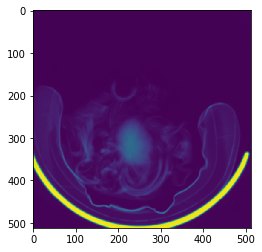

In [107]:
plt.imshow(pixels[])

In [120]:
p=np.where(pixels>300,300,pixels)

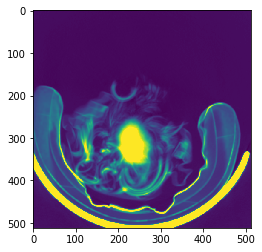

In [121]:
plt.imshow(p)

In [43]:
float(torch.tensor(pixels).min())

-0.8279600345704523

In [4]:
import smtplib


In [5]:
#email properties
sent_from = gmail_user
to = ['yuval6967@gmail.com']
subject = 'hello world'
email_text ='Subject: asaf \nhello world'




In [18]:
str_list=['Subject:{}\n'.format('fff')]+ [str(d)[1:-2]+'\n' for d in h]
email_text=''.join(str_list).replace("'",'').replace(':','')           
print(email_text)

Subjectfff
loss 0.08779796887303448, val_loss 0.0882729854947770
loss 0.0883496887303448, val_loss 0.033329854947770
loss 0.022296887303448, val_loss 0.044429854947770
loss 0.011196887303448, val_loss 0.0777854947770



In [19]:
try:
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, email_text)
    server.close()

    print ('Email sent!')
except Exception as e:
    print(e)
    print ('Something went wrong...')

(250,
 b'smtp.gmail.com at your service, [109.186.76.48]\nSIZE 35882577\n8BITMIME\nAUTH LOGIN PLAIN XOAUTH2 PLAIN-CLIENTTOKEN OAUTHBEARER XOAUTH\nENHANCEDSTATUSCODES\nPIPELINING\nCHUNKING\nSMTPUTF8')

(235, b'2.7.0 Accepted')

{}

Email sent!


In [24]:
def ttt(*parameters):
    print ('a{} b{}'.format(*parameters))

In [25]:
ttt(1,2)

a1 b2


In [2]:
em=Email_Progress(my_gmail,my_pass,to_email,'my test')

In [3]:
h = [{'loss': 0.08779796887303448, 'val_loss': 0.08827298549477702},
    {'loss': 0.0883496887303448, 'val_loss': 0.0333298549477702},
     {'loss': 0.022296887303448, 'val_loss': 0.0444298549477702},
    {'loss': 0.011196887303448, 'val_loss': 0.07778549477702}]
em(h)

0

In [5]:
str_list=['Subject:{}\n'.format('fff')]+[str(d)[1:-2]+'\n' for d in h]
email_text=''.join(str_list).strip('{}')            
print(email_text)

Subject:fff
'loss': 0.08779796887303448, 'val_loss': 0.0882729854947770
'loss': 0.0883496887303448, 'val_loss': 0.033329854947770
'loss': 0.022296887303448, 'val_loss': 0.044429854947770
'loss': 0.011196887303448, 'val_loss': 0.0777854947770



In [5]:
myObj = [1,2,3]
hasattr(myObj, '__iter__')

True

In [16]:
a=train_df.SeriesI.values

In [20]:
inx=np.arange(a.shape[0])
np.random.shuffle(inx)
u,ui = np.unique(a[inx],return_index=True)

In [4]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [20]:

s = sampler(train_df[hemorrhage_types].values,3,[0,0,0,0,0,1.2],unique_col=train_df.SeriesI.values)


In [21]:
a=s()

In [22]:
a.shape[0]/12

5682.75

In [23]:
a.shape[0]/train_df.shape[0]

0.10110005781975064

In [24]:
a.shape

(188800,)

In [15]:
train_df[hemorrhage_types].values.sum(0)
train_df[hemorrhage_types].values.sum(0)/train_df.shape[0]
train_df[hemorrhage_types].values[a].sum(0)
train_df[hemorrhage_types].values[a].sum(0)/a.shape[0]
train_df[hemorrhage_types].values.sum(0)/train_df[hemorrhage_types].values[a].sum(0)
(train_df[hemorrhage_types].values.sum(1)==0).sum()/(train_df[hemorrhage_types].values[a].sum(1)==0).sum()

array([ 2761, 32564, 23766, 32122, 42496, 97103])

array([0.00409334, 0.04827801, 0.03523447, 0.04762272, 0.06300277,
       0.1439608 ])

array([  439,  6193,  3698,  4548,  5715, 16006])

array([0.00386253, 0.05448898, 0.03253678, 0.04001549, 0.05028331,
       0.14082846])

array([6.28929385, 5.25819474, 6.42671714, 7.06288478, 7.43587052,
       6.0666625 ])

5.913026113671275

In [50]:
a=10*torch.randn(24).reshape(2,3,4)+232
a_=a.transpose(0,-1)
m = a.mean(-1).mean(-1)

b=((a_-m)/torch.norm(a_-m,dim=(0,1))).transpose(0,-1)
b

tensor([[[ 0.3949, -0.2255, -0.3581, -0.2374],
         [-0.4197,  0.3315, -0.0165, -0.0232],
         [-0.2614,  0.4162,  0.1844,  0.2148]],

        [[-0.2016,  0.0684,  0.1156,  0.1902],
         [-0.6138, -0.1541,  0.0040,  0.2804],
         [ 0.1804, -0.2495,  0.5499, -0.1698]]])

In [51]:
b[1].mean()
b[1].std()

tensor(-6.8297e-08)

tensor(0.3015)

In [36]:
~any([i for i in []])

-1

In [25]:
h={'loss':20, 'val':90}

In [26]:
str(h)

"{'loss': 20, 'val': 90}"

In [16]:
lambd = np.random.beta(0.2,0.2, 2048)
lambd1 = np.abs(lambd-0.5)+0.5 #
lambd2 = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
(lambd1==lambd2).all()
#lambd1
#lambd2

False

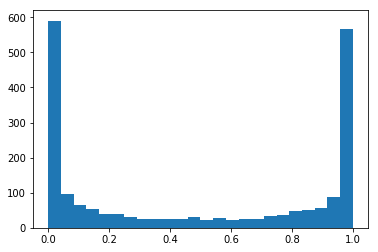

In [17]:
_=plt.hist(lambd,24)

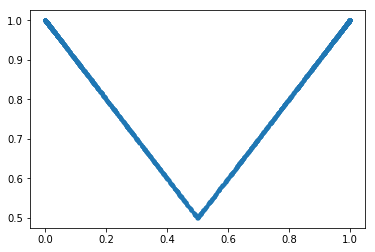

In [15]:
_=plt.plot(lambd,lambd2,'.')

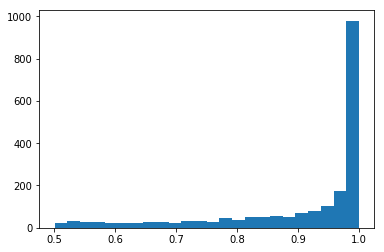

In [18]:
_=plt.hist(lambd2,24)

In [2]:
model0 = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')

Using cache found in /home/reina/.cache/torch/hub/facebookresearch_WSL-Images_master


In [3]:
[n for n,p in model0.named_parameters()]

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.0.conv3.weight',
 'layer1.0.bn3.weight',
 'layer1.0.bn3.bias',
 'layer1.0.downsample.0.weight',
 'layer1.0.downsample.1.weight',
 'layer1.0.downsample.1.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer1.1.conv3.weight',
 'layer1.1.bn3.weight',
 'layer1.1.bn3.bias',
 'layer1.2.conv1.weight',
 'layer1.2.bn1.weight',
 'layer1.2.bn1.bias',
 'layer1.2.conv2.weight',
 'layer1.2.bn2.weight',
 'layer1.2.bn2.bias',
 'layer1.2.conv3.weight',
 'layer1.2.bn3.weight',
 'layer1.2.bn3.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.conv3.weight',
 'layer2.0.bn3.weight',
 'layer2.0.bn3.b

In [4]:
model1 = MySENet(model0,
                len(hemorrhage_types),
                wso=((40,80),(80,200),(600,2800)),
                dont_do_grad=[],
                extra_pool=4)

In [5]:
[n for n,p in model1.named_parameters()]

['features.wso_conv.weight',
 'features.wso_conv.bias',
 'features.layer0.conv1.weight',
 'features.layer0.bn1.weight',
 'features.layer0.bn1.bias',
 'features.layer1.0.conv1.weight',
 'features.layer1.0.bn1.weight',
 'features.layer1.0.bn1.bias',
 'features.layer1.0.conv2.weight',
 'features.layer1.0.bn2.weight',
 'features.layer1.0.bn2.bias',
 'features.layer1.0.conv3.weight',
 'features.layer1.0.bn3.weight',
 'features.layer1.0.bn3.bias',
 'features.layer1.0.downsample.0.weight',
 'features.layer1.0.downsample.1.weight',
 'features.layer1.0.downsample.1.bias',
 'features.layer1.1.conv1.weight',
 'features.layer1.1.bn1.weight',
 'features.layer1.1.bn1.bias',
 'features.layer1.1.conv2.weight',
 'features.layer1.1.bn2.weight',
 'features.layer1.1.bn2.bias',
 'features.layer1.1.conv3.weight',
 'features.layer1.1.bn3.weight',
 'features.layer1.1.bn3.bias',
 'features.layer1.2.conv1.weight',
 'features.layer1.2.bn1.weight',
 'features.layer1.2.bn1.bias',
 'features.layer1.2.conv2.weight',

In [7]:
[module for module in model1.modules()]

[MySENet(
   (features): Sequential(
     (wso_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
     (wso_relu): Sigmoid()
     (wso_norm): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (layer0): Sequential(
       (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
         (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256,

In [8]:
torch.utils.cpp_extension

AttributeError: module 'torch.utils' has no attribute 'cpp_extension'

In [9]:
import torch
from setuptools import setup, find_packages
import subprocess

from pip._internal import main as pipmain
import sys
import warnings
import os

if not torch.cuda.is_available():
    # https://github.com/NVIDIA/apex/issues/486
    # Extension builds after https://github.com/pytorch/pytorch/pull/23408 attempt to query torch.cuda.get_device_capability(),
    # which will fail if you are compiling in an environment without visible GPUs (e.g. during an nvidia-docker build command).
    print('\nWarning: Torch did not find available GPUs on this system.\n',
          'If your intention is to cross-compile, this is not an error.\n'
          'By default, Apex will cross-compile for Pascal (compute capabilities 6.0, 6.1, 6.2),\n'
          'Volta (compute capability 7.0), and Turing (compute capability 7.5).\n'
          'If you wish to cross-compile for a single specific architecture,\n'
          'export TORCH_CUDA_ARCH_LIST="compute capability" before running setup.py.\n')
    if os.environ.get("TORCH_CUDA_ARCH_LIST", None) is None:
        os.environ["TORCH_CUDA_ARCH_LIST"] = "6.0;6.1;6.2;7.0;7.5"

print("torch.__version__  = ", torch.__version__)
TORCH_MAJOR = int(torch.__version__.split('.')[0])
TORCH_MINOR = int(torch.__version__.split('.')[1])


torch.__version__  =  1.2.0


In [10]:
cmdclass = {}
ext_modules = []
from torch.utils.cpp_extension import BuildExtension
cmdclass['build_ext'] = BuildExtension


In [11]:
from torch.utils.cpp_extension import CUDAExtension


In [12]:
torch.utils.cpp_extension.CUDA_HOME

'/usr'

In [13]:
subprocess.check_output([torch.utils.cpp_extension.CUDA_HOME + "/bin/nvcc", "-V"], universal_newlines=True)

'nvcc: NVIDIA (R) Cuda compiler driver\nCopyright (c) 2005-2017 NVIDIA Corporation\nBuilt on Fri_Nov__3_21:07:56_CDT_2017\nCuda compilation tools, release 9.1, V9.1.85\n'

In [ ]:
torch.max()

In [2]:
class Window(nn.Module):
    def forward(self, x):
        return torch.clamp(x,0,1)


In [3]:
c=Window()

In [19]:
a=torch.randn(10,3,40,40)*3+torch.randn(10,3,40,40)*3


In [21]:
b = nr(a)

In [22]:
b.shape

torch.Size([10, 3, 40, 40])

In [23]:
b[9,2].std()

tensor(1.0003)

In [24]:
a[9,2].std()

tensor(4.1166)

In [4]:
wso=wso=((40,80),(80,200),(600,2800))

In [15]:
wn=nn.Sigmoid()

In [6]:
nr = nn.InstanceNorm2d(3,eps=1e-10)

In [7]:
conv_ = nn.Conv2d(1,3, kernel_size=(1, 1))
conv_.weight.data.copy_(torch.tensor([[[[1./wso[0][1]]]],[[[1./wso[1][1]]]],[[[1./wso[2][1]]]]],dtype=torch.double))
conv_.bias.data.copy_(torch.tensor([0.5 - wso[0][0]/wso[0][1],
                                        0.5 - wso[1][0]/wso[1][1],
                                        0.5 -wso[2][0]/wso[2][1]],dtype=torch.double))


tensor([[[[0.0125]]],


        [[[0.0050]]],


        [[[0.0004]]]])

tensor([0.0000, 0.1000, 0.2857])

In [89]:
conv_.weight.data.copy_(torch.tensor([[[[0.0125]]],[[[0]]],[[[0]]]],dtype=torch.double))
conv_.bias.data.copy_(torch.tensor([0.0000, 0, 0],dtype=torch.double))


tensor([[[[0.0125]]],


        [[[0.0000]]],


        [[[0.0000]]]])

tensor([0., 0., 0.])

In [75]:
a=torch.ones((1,1,512,512),dtype=torch.float)
conv_(a).detach()[0,0,:10,:10]

tensor([[0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125]])

In [8]:
pixels = torch.tensor(load_one_image(train_df.PatientID.values[2],equalize=False,window_eq=False,rescale=True),dtype=torch.float).unsqueeze(0).unsqueeze(0)

In [16]:
px = wn(conv_(pixels))
px.require_grad=False

In [10]:
px2 = torch.tensor(load_one_image(train_df.PatientID.values[2],equalize=False,window_eq=3,rescale=False),dtype=torch.float)

In [11]:
px[0,0,130:135,230:235]/px2[0,130:135,230:235]

tensor([[0.9875, 0.9875, 0.9875, 0.9875, 0.9875],
        [0.9875, 0.9875, 0.9875, 0.9875,    nan],
        [0.9875, 0.9875, 0.9875,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan]], grad_fn=<DivBackward0>)

In [82]:
px2[0,130:135,230:235]

tensor([[0.3038, 0.4051, 0.4810, 0.3797, 0.1899],
        [0.4177, 0.4051, 0.3924, 0.1772, 0.0000],
        [0.3038, 0.2152, 0.1013, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

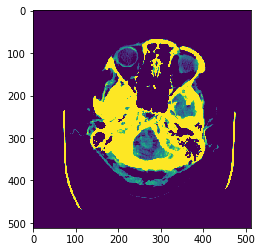

In [77]:
plt.imshow(px2.numpy()[0])

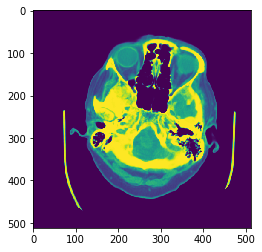

In [17]:
plt.imshow(px.squeeze().detach().numpy()[0])

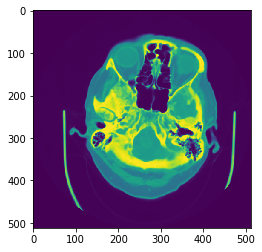

In [18]:
plt.imshow(px.squeeze().detach().numpy()[1])

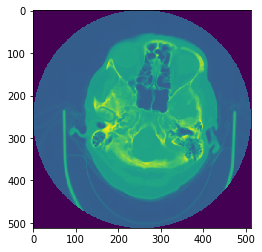

In [19]:
plt.imshow(px.squeeze().detach().numpy()[2])

In [77]:
torch.empty(3,3, 4, 5).size()[2:]+(1,)

torch.Size([4, 5, 1])

In [6]:
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))

transform_val=MyTransform(out_size=512)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,
                               window_eq=False,equalize=False,rescale=True)
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
data_loader=D.DataLoader(combined_dataset_val,batch_size=24,shuffle=False,num_workers=4)

In [9]:
batch = next(iter(data_loader))

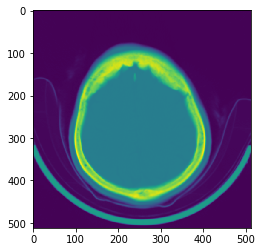

In [25]:
plt.imshow(batch[0][0].squeeze().numpy())

In [22]:
mixup=Mixup(0.4,device='cpu')

In [23]:
batchm=mixup(batch[0],batch[1])

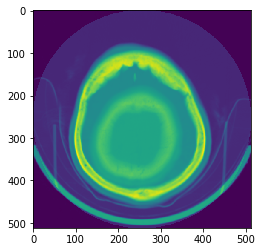

In [26]:
plt.imshow(batchm[0][0].squeeze().numpy())

In [29]:
batchm[1][0]

tensor([[0.0000, 0.0000, 0.7826],
        [0.0000, 0.0000, 0.7826],
        [0.0000, 0.0000, 0.7826],
        [0.0000, 0.0000, 0.7826],
        [0.0000, 1.0000, 0.7826],
        [0.0000, 1.0000, 0.7826]])

In [33]:
batchm[1][...,2]

tensor([[0.7826, 0.7826, 0.7826, 0.7826, 0.7826, 0.7826],
        [0.5594, 0.5594, 0.5594, 0.5594, 0.5594, 0.5594],
        [0.8611, 0.8611, 0.8611, 0.8611, 0.8611, 0.8611],
        [0.6838, 0.6838, 0.6838, 0.6838, 0.6838, 0.6838],
        [0.9734, 0.9734, 0.9734, 0.9734, 0.9734, 0.9734],
        [0.8235, 0.8235, 0.8235, 0.8235, 0.8235, 0.8235],
        [0.9717, 0.9717, 0.9717, 0.9717, 0.9717, 0.9717],
        [0.5555, 0.5555, 0.5555, 0.5555, 0.5555, 0.5555],
        [0.9305, 0.9305, 0.9305, 0.9305, 0.9305, 0.9305],
        [0.8085, 0.8085, 0.8085, 0.8085, 0.8085, 0.8085],
        [0.9855, 0.9855, 0.9855, 0.9855, 0.9855, 0.9855],
        [0.9949, 0.9949, 0.9949, 0.9949, 0.9949, 0.9949],
        [0.9943, 0.9943, 0.9943, 0.9943, 0.9943, 0.9943],
        [0.5531, 0.5531, 0.5531, 0.5531, 0.5531, 0.5531],
        [0.7996, 0.7996, 0.7996, 0.7996, 0.7996, 0.7996],
        [0.7596, 0.7596, 0.7596, 0.7596, 0.7596, 0.7596],
        [0.6603, 0.6603, 0.6603, 0.6603, 0.6603, 0.6603],
        [0.985

In [34]:
from pytorchcv.model_provider import get_model as ptcv_get_model

In [ ]:
ptcv_get_model("efficientnet_b5b", pretrained=True)

$$\|A\|_1 = \max_{1 \leq j \leq n} \sum_{i=1}^m | a_{ij} |$$


In [46]:
a=torch.arange(48).reshape(8,6)
w = torch.tensor([1,2,3,4,5,6])
w.expand_as(a)

tensor([[1, 2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5, 6]])

In [47]:
a

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35],
        [36, 37, 38, 39, 40, 41],
        [42, 43, 44, 45, 46, 47]])

In [48]:
torch.einsum('ij,j->i',a,w)

tensor([ 70, 196, 322, 448, 574, 700, 826, 952])

In [49]:
torch.matmul(a,w)

tensor([ 70, 196, 322, 448, 574, 700, 826, 952])

In [54]:
MyDenseNet?

In [58]:
def stam(a,b):
    a.t=a*b

In [63]:
a=np.array([1,2,3])
stam(a,a)

AttributeError: 'numpy.ndarray' object has no attribute 't'

In [61]:
a.g

tensor([[  0,   2,   6,  12,  20,  30],
        [  6,  14,  24,  36,  50,  66],
        [ 12,  26,  42,  60,  80, 102],
        [ 18,  38,  60,  84, 110, 138],
        [ 24,  50,  78, 108, 140, 174],
        [ 30,  62,  96, 132, 170, 210],
        [ 36,  74, 114, 156, 200, 246],
        [ 42,  86, 132, 180, 230, 282]])